## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/solubility/solub_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_pubchem_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train_all = df_train_all['solubility']

X_train = df_train.loc[:, df_train.columns != 'solubility']
y_train = df_train['solubility']

X_test = df_test.loc[:, df_test.columns != 'solubility']
y_test = df_test['solubility']

X_valid = df_valid.loc[:, df_valid.columns != 'solubility']
y_valid = df_valid['solubility']

In [5]:
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['solubility']]
X_train = X_train[idxs['solubility']]
X_test = X_test[idxs['solubility']]
X_valid = X_valid[idxs['solubility']]

In [6]:
X_train.shape

(1234, 474)

In [7]:
X_test.shape

(353, 474)

In [8]:
X_valid.shape

(176, 474)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [9]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(474, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [10]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [11]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=176, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 4.210599755629515, Accuracy: -3.713546421842431
Test Avg. loss: 7.1027679443359375, Accuracy: -7.799872413466897
################## EPOCH 2 ##################
Train Avg. loss: 2.4172749580481114, Accuracy: -1.7177818396099587
Test Avg. loss: 3.6625819206237793, Accuracy: -3.5377025883325928
################## EPOCH 3 ##################
Train Avg. loss: 2.1994782900198913, Accuracy: -1.4737087974598786
Test Avg. loss: 3.409383773803711, Accuracy: -3.224006614810058
################## EPOCH 4 ##################
Train Avg. loss: 2.0423895120620728, Accuracy: -1.2955425244310332
Test Avg. loss: 2.3577725887298584, Accuracy: -1.9211284383701108
################## EPOCH 5 ##################
Train Avg. loss: 1.97751500362005, Accuracy: -1.185433596820883
Test Avg. loss: 3.179619550704956, Accuracy: -2.9393440601881506
################## EPOCH 6 ##################
Train Avg. loss: 1.9962894672002547, 

Train Avg. loss: 1.2695394968375182, Accuracy: -0.40018963146237757
Test Avg. loss: 1.3830639123916626, Accuracy: -0.7135270813560566
################## EPOCH 48 ##################
Train Avg. loss: 1.26569153712346, Accuracy: -0.41677000544603926
Test Avg. loss: 1.3960325717926025, Accuracy: -0.7295943385009047
################## EPOCH 49 ##################
Train Avg. loss: 1.241536863339253, Accuracy: -0.3938940640654597
Test Avg. loss: 1.5189852714538574, Accuracy: -0.8819249936244324
################## EPOCH 50 ##################
Train Avg. loss: 1.2316346627015333, Accuracy: -0.37220457367034077
Test Avg. loss: 1.331987738609314, Accuracy: -0.6502470062819148
################## EPOCH 51 ##################
Train Avg. loss: 1.1954422715382698, Accuracy: -0.343843329347514
Test Avg. loss: 1.2227996587753296, Accuracy: -0.5149700808037518
################## EPOCH 52 ##################
Train Avg. loss: 1.235938494022076, Accuracy: -0.3845448902174149
Test Avg. loss: 1.1019212007522583, 

Train Avg. loss: 0.8235860321766291, Accuracy: 0.06512360106186173
Test Avg. loss: 0.8455525636672974, Accuracy: -0.04758520097651964
################## EPOCH 94 ##################
Train Avg. loss: 0.8399056249704117, Accuracy: 0.07344102347282926
Test Avg. loss: 0.9150628447532654, Accuracy: -0.13370388654852206
################## EPOCH 95 ##################
Train Avg. loss: 0.8442213084453192, Accuracy: 0.05228195782819832
Test Avg. loss: 1.019303321838379, Accuracy: -0.26285108201465546
################## EPOCH 96 ##################
Train Avg. loss: 0.7487872602083744, Accuracy: 0.16520997142752308
Test Avg. loss: 0.8710415959358215, Accuracy: -0.07916439464421754
################## EPOCH 97 ##################
Train Avg. loss: 0.7744699158729651, Accuracy: 0.13861830721955037
Test Avg. loss: 0.8579934239387512, Accuracy: -0.06299858298588079
################## EPOCH 98 ##################
Train Avg. loss: 0.809217841961445, Accuracy: 0.07645332796237685
Test Avg. loss: 0.816598594188

Train Avg. loss: 0.5530855571612333, Accuracy: 0.38203572329925567
Test Avg. loss: 0.8030294179916382, Accuracy: 0.005098286566106003
################## EPOCH 140 ##################
Train Avg. loss: 0.5403662331593342, Accuracy: 0.3837827320331922
Test Avg. loss: 0.7973340749740601, Accuracy: 0.01215438547149117
################## EPOCH 141 ##################
Train Avg. loss: 0.5076770767187461, Accuracy: 0.4201841720587355
Test Avg. loss: 0.8496761322021484, Accuracy: -0.0526939466727494
################## EPOCH 142 ##################
Train Avg. loss: 0.5596136771715604, Accuracy: 0.37441664700415705
Test Avg. loss: 0.7450036406517029, Accuracy: 0.07698846185061015
################## EPOCH 143 ##################
Train Avg. loss: 0.5438844989507626, Accuracy: 0.3917371319569748
Test Avg. loss: 0.8365076780319214, Accuracy: -0.036379079434375905
################## EPOCH 144 ##################
Train Avg. loss: 0.5219269211475666, Accuracy: 0.41519893813558656
Test Avg. loss: 0.7741017937

Train Avg. loss: 0.3886876071874912, Accuracy: 0.5636016511299258
Test Avg. loss: 0.7642562389373779, Accuracy: 0.05313580693875175
################## EPOCH 186 ##################
Train Avg. loss: 0.40333203971385956, Accuracy: 0.5435345402553163
Test Avg. loss: 0.740810751914978, Accuracy: 0.0821831902987813
################## EPOCH 187 ##################
Train Avg. loss: 0.39159532540883774, Accuracy: 0.5563130885618718
Test Avg. loss: 0.7405266761779785, Accuracy: 0.08253517050844106
################## EPOCH 188 ##################
Train Avg. loss: 0.38581175605456036, Accuracy: 0.5641740258742362
Test Avg. loss: 0.8474608659744263, Accuracy: -0.049949382728247116
################## EPOCH 189 ##################
Train Avg. loss: 0.410275637339323, Accuracy: 0.5367619663803379
Test Avg. loss: 0.7810502648353577, Accuracy: 0.032329059444830666
################## EPOCH 190 ##################
Train Avg. loss: 0.4009826668562033, Accuracy: 0.5463854734274264
Test Avg. loss: 0.7947729229927

Train Avg. loss: 0.33660500095440793, Accuracy: 0.6190655431603103
Test Avg. loss: 0.7624507546424866, Accuracy: 0.055372659863664686
################## EPOCH 232 ##################
Train Avg. loss: 0.31116447234765077, Accuracy: 0.6548932799352852
Test Avg. loss: 0.7498636245727539, Accuracy: 0.07096722465752014
################## EPOCH 233 ##################
Train Avg. loss: 0.32918318724020934, Accuracy: 0.626043993511563
Test Avg. loss: 0.7616934776306152, Accuracy: 0.05631083148032845
################## EPOCH 234 ##################
Train Avg. loss: 0.31053860791218585, Accuracy: 0.6468603644002991
Test Avg. loss: 0.7282806038856506, Accuracy: 0.09770723457634334
################## EPOCH 235 ##################
Train Avg. loss: 0.3229285027736273, Accuracy: 0.6351091126699822
Test Avg. loss: 0.7445545196533203, Accuracy: 0.07754487537162646
################## EPOCH 236 ##################
Train Avg. loss: 0.29549135955480427, Accuracy: 0.6630967361353013
Test Avg. loss: 0.75771540403

Train Avg. loss: 0.25312033181007093, Accuracy: 0.7146092403691686
Test Avg. loss: 0.7986552715301514, Accuracy: 0.010517521131155227
################## EPOCH 278 ##################
Train Avg. loss: 0.2615057038955199, Accuracy: 0.70786468892371
Test Avg. loss: 0.7846622467041016, Accuracy: 0.02785405928429019
################## EPOCH 279 ##################
Train Avg. loss: 0.28169785401760006, Accuracy: 0.6858215665988013
Test Avg. loss: 0.7588422894477844, Accuracy: 0.05984322239672246
################## EPOCH 280 ##################
Train Avg. loss: 0.26984862199960613, Accuracy: 0.6987814823847083
Test Avg. loss: 0.7711198329925537, Accuracy: 0.044632228356059844
################## EPOCH 281 ##################
Train Avg. loss: 0.25436659023547786, Accuracy: 0.7121021433340469
Test Avg. loss: 0.7579544186592102, Accuracy: 0.06094325660464861
################## EPOCH 282 ##################
Train Avg. loss: 0.2613144560884207, Accuracy: 0.7097363399355553
Test Avg. loss: 0.780401885509

Train Avg. loss: 1.9821979641914367, Accuracy: -1.1414904667125056
Test Avg. loss: 1.825243353843689, Accuracy: -1.261358961459519
################## EPOCH 25 ##################
Train Avg. loss: 1.9422587275505065, Accuracy: -1.0953303409098543
Test Avg. loss: 1.6987993717193604, Accuracy: -1.1047029691294323
################## EPOCH 26 ##################
Train Avg. loss: 1.9148729205131532, Accuracy: -1.0700289365870317
Test Avg. loss: 1.7282259464263916, Accuracy: -1.1411605052314915
################## EPOCH 27 ##################
Train Avg. loss: 1.785472321510315, Accuracy: -0.9377243043954984
Test Avg. loss: 1.685930848121643, Accuracy: -1.0887597155193864
################## EPOCH 28 ##################
Train Avg. loss: 1.8580339431762696, Accuracy: -1.0102744924672753
Test Avg. loss: 1.7479619979858398, Accuracy: -1.1656123281983444
################## EPOCH 29 ##################
Train Avg. loss: 1.7808303713798523, Accuracy: -0.9210956616008185
Test Avg. loss: 1.9421724081039429, A

Train Avg. loss: 1.381696990132332, Accuracy: -0.506991046258251
Test Avg. loss: 1.3988605737686157, Accuracy: -0.7330982192379158
################## EPOCH 72 ##################
Train Avg. loss: 1.3513410478830337, Accuracy: -0.4615630810774468
Test Avg. loss: 1.5150701999664307, Accuracy: -0.8770742536882004
################## EPOCH 73 ##################
Train Avg. loss: 1.4941164612770081, Accuracy: -0.6231365070562053
Test Avg. loss: 1.7851579189300537, Accuracy: -1.2116956384592865
################## EPOCH 74 ##################
Train Avg. loss: 1.357835978269577, Accuracy: -0.4791435020244891
Test Avg. loss: 1.5038775205612183, Accuracy: -0.8632072225459366
################## EPOCH 75 ##################
Train Avg. loss: 1.2643503278493882, Accuracy: -0.3872756104931664
Test Avg. loss: 1.5069053173065186, Accuracy: -0.8669586500483843
################## EPOCH 76 ##################
Train Avg. loss: 1.4013070851564406, Accuracy: -0.5131912165089373
Test Avg. loss: 1.309403657913208, A

Train Avg. loss: 1.032191562652588, Accuracy: -0.12523124610375697
Test Avg. loss: 1.474713683128357, Accuracy: -0.8270752301473718
################## EPOCH 119 ##################
Train Avg. loss: 0.9470506489276886, Accuracy: -0.03898014350996652
Test Avg. loss: 1.5038076639175415, Accuracy: -0.8631207708043711
################## EPOCH 120 ##################
Train Avg. loss: 0.9888041973114013, Accuracy: -0.07267575438270055
Test Avg. loss: 1.4025392532348633, Accuracy: -0.7376557845155076
################## EPOCH 121 ##################
Train Avg. loss: 1.0037712842226028, Accuracy: -0.10287933718895137
Test Avg. loss: 1.3151320219039917, Accuracy: -0.6293639372736322
################## EPOCH 122 ##################
Train Avg. loss: 0.9420326828956604, Accuracy: -0.029163627319912934
Test Avg. loss: 1.3409932851791382, Accuracy: -0.6614042868489975
################## EPOCH 123 ##################
Train Avg. loss: 0.9953503429889679, Accuracy: -0.08152532271220825
Test Avg. loss: 1.16799

Train Avg. loss: 0.7372673764824867, Accuracy: 0.19669036904814666
Test Avg. loss: 0.9653478264808655, Accuracy: -0.1960037459212245
################## EPOCH 165 ##################
Train Avg. loss: 0.7601360708475113, Accuracy: 0.17651430278052635
Test Avg. loss: 1.0942986011505127, Accuracy: -0.35576550010032637
################## EPOCH 166 ##################
Train Avg. loss: 0.798677945137024, Accuracy: 0.1306284942463053
Test Avg. loss: 1.0818501710891724, Accuracy: -0.34034271796354676
################## EPOCH 167 ##################
Train Avg. loss: 0.7512768536806107, Accuracy: 0.1826421483525052
Test Avg. loss: 0.9826841354370117, Accuracy: -0.21748235009780403
################## EPOCH 168 ##################
Train Avg. loss: 0.7755008965730668, Accuracy: 0.159238311020538
Test Avg. loss: 0.9594475626945496, Accuracy: -0.18869369817674397
################## EPOCH 169 ##################
Train Avg. loss: 0.6999774053692818, Accuracy: 0.2410149530054718
Test Avg. loss: 1.029902696609

Train Avg. loss: 0.607810266315937, Accuracy: 0.34133157905511863
Test Avg. loss: 0.8571255803108215, Accuracy: -0.061923402119417936
################## EPOCH 212 ##################
Train Avg. loss: 0.6109431773424149, Accuracy: 0.3345892565447562
Test Avg. loss: 0.7999935150146484, Accuracy: 0.008859406035172657
################## EPOCH 213 ##################
Train Avg. loss: 0.5503329828381538, Accuracy: 0.40014834790481124
Test Avg. loss: 0.8986360430717468, Accuracy: -0.1133523268034633
################## EPOCH 214 ##################
Train Avg. loss: 0.5593961700797081, Accuracy: 0.39114456532595304
Test Avg. loss: 0.8693747520446777, Accuracy: -0.07709929840997742
################## EPOCH 215 ##################
Train Avg. loss: 0.5733392730355262, Accuracy: 0.38090033098718606
Test Avg. loss: 0.9583012461662292, Accuracy: -0.18727341556767985
################## EPOCH 216 ##################
Train Avg. loss: 0.5817004904150963, Accuracy: 0.361690085973409
Test Avg. loss: 0.914664268

Train Avg. loss: 0.43181640058755877, Accuracy: 0.5341479036127791
Test Avg. loss: 0.8191624879837036, Accuracy: -0.014889591750098852
################## EPOCH 258 ##################
Train Avg. loss: 0.4078058525919914, Accuracy: 0.5555673425900098
Test Avg. loss: 0.8105476498603821, Accuracy: -0.0042163844306946086
################## EPOCH 259 ##################
Train Avg. loss: 0.4394072502851486, Accuracy: 0.520431109652257
Test Avg. loss: 0.778893768787384, Accuracy: 0.035000847667095436
################## EPOCH 260 ##################
Train Avg. loss: 0.4541385889053345, Accuracy: 0.506839547830137
Test Avg. loss: 0.7992108464241028, Accuracy: 0.009829186609707885
################## EPOCH 261 ##################
Train Avg. loss: 0.3940889447927475, Accuracy: 0.574542632582645
Test Avg. loss: 0.8264268636703491, Accuracy: -0.023889619932075945
################## EPOCH 262 ##################
Train Avg. loss: 0.4115209192037582, Accuracy: 0.5531999162147891
Test Avg. loss: 0.7589510083

Train Avg. loss: 2.241479754447937, Accuracy: -1.3756274185053559
Test Avg. loss: 4.454551696777344, Accuracy: -4.518902429674728
################## EPOCH 5 ##################
Train Avg. loss: 2.0639824867248535, Accuracy: -1.1867177798090385
Test Avg. loss: 4.195993423461914, Accuracy: -4.198565559509226
################## EPOCH 6 ##################
Train Avg. loss: 2.1201030135154726, Accuracy: -1.2305533073752257
Test Avg. loss: 2.239182949066162, Accuracy: -1.7742034996242984
################## EPOCH 7 ##################
Train Avg. loss: 1.9733174443244934, Accuracy: -1.0823310151718937
Test Avg. loss: 2.9655935764312744, Accuracy: -2.6741792713460613
################## EPOCH 8 ##################
Train Avg. loss: 1.977229404449463, Accuracy: -1.0868316962269928
Test Avg. loss: 2.4754345417022705, Accuracy: -2.0669037438610616
################## EPOCH 9 ##################
Train Avg. loss: 1.8972918748855592, Accuracy: -1.010798395627534
Test Avg. loss: 2.4633378982543945, Accuracy: 

Train Avg. loss: 1.5915392756462097, Accuracy: -0.6741257145199829
Test Avg. loss: 2.5354766845703125, Accuracy: -2.141292062123745
################## EPOCH 51 ##################
Train Avg. loss: 1.5170140743255616, Accuracy: -0.6067264824259055
Test Avg. loss: 2.8406779766082764, Accuracy: -2.5194170310794286
################## EPOCH 52 ##################
Train Avg. loss: 1.6229993462562562, Accuracy: -0.7104208454913096
Test Avg. loss: 2.829846143722534, Accuracy: -2.5059969912229065
################## EPOCH 53 ##################
Train Avg. loss: 1.628211259841919, Accuracy: -0.7270548412153179
Test Avg. loss: 2.01375412940979, Accuracy: -1.494911689571103
################## EPOCH 54 ##################
Train Avg. loss: 1.6376466155052185, Accuracy: -0.7320607818350677
Test Avg. loss: 1.9513206481933594, Accuracy: -1.417560759601189
################## EPOCH 55 ##################
Train Avg. loss: 1.6281923174858093, Accuracy: -0.7131937718766279
Test Avg. loss: 1.848817229270935, Accur

Train Avg. loss: 1.3521366953849792, Accuracy: -0.4280156663884064
Test Avg. loss: 1.5947706699371338, Accuracy: -0.975818115945702
################## EPOCH 98 ##################
Train Avg. loss: 1.3908111333847046, Accuracy: -0.46129651368556435
Test Avg. loss: 1.6507329940795898, Accuracy: -1.0451518884941842
################## EPOCH 99 ##################
Train Avg. loss: 1.3282865762710572, Accuracy: -0.4013409227199958
Test Avg. loss: 1.937071442604065, Accuracy: -1.3999068731668243
################## EPOCH 100 ##################
Train Avg. loss: 1.2539706110954285, Accuracy: -0.3262943431331048
Test Avg. loss: 2.193849802017212, Accuracy: -1.71803844482289
################## EPOCH 101 ##################
Train Avg. loss: 1.2045932114124298, Accuracy: -0.2749477450029668
Test Avg. loss: 2.3687474727630615, Accuracy: -1.934725419272024
################## EPOCH 102 ##################
Train Avg. loss: 1.3130652189254761, Accuracy: -0.3916202252825972
Test Avg. loss: 2.2941648960113525,

Train Avg. loss: 1.0938305139541626, Accuracy: -0.15820886270033324
Test Avg. loss: 1.3942455053329468, Accuracy: -0.7273802747887277
################## EPOCH 145 ##################
Train Avg. loss: 1.0602243900299073, Accuracy: -0.11841866552125797
Test Avg. loss: 1.72256600856781, Accuracy: -1.1341483154039667
################## EPOCH 146 ##################
Train Avg. loss: 1.2000066637992859, Accuracy: -0.2676456710566339
Test Avg. loss: 1.921130895614624, Accuracy: -1.3801571670437975
################## EPOCH 147 ##################
Train Avg. loss: 1.1858485281467437, Accuracy: -0.25243198929605215
Test Avg. loss: 1.3993422985076904, Accuracy: -0.7336950651590466
################## EPOCH 148 ##################
Train Avg. loss: 1.2088807940483093, Accuracy: -0.27493681358622385
Test Avg. loss: 1.5594552755355835, Accuracy: -0.9320643706011158
################## EPOCH 149 ##################
Train Avg. loss: 1.0672319293022157, Accuracy: -0.1278821867730054
Test Avg. loss: 1.530371785

Train Avg. loss: 0.9411257326602935, Accuracy: 0.010354807296756207
Test Avg. loss: 1.3371061086654663, Accuracy: -0.6565882971624215
################## EPOCH 193 ##################
Train Avg. loss: 0.9393816769123078, Accuracy: 0.009501151731438418
Test Avg. loss: 1.324399471282959, Accuracy: -0.6408455668424424
################## EPOCH 194 ##################
Train Avg. loss: 0.9281544923782349, Accuracy: 0.014512993541147856
Test Avg. loss: 1.4401719570159912, Accuracy: -0.7842801911067516
################## EPOCH 195 ##################
Train Avg. loss: 0.9168690979480744, Accuracy: 0.03852983680247479
Test Avg. loss: 1.2222723960876465, Accuracy: -0.5143166639866399
################## EPOCH 196 ##################
Train Avg. loss: 0.9460048854351044, Accuracy: 0.0033543341634549085
Test Avg. loss: 1.2786064147949219, Accuracy: -0.58411090005633
################## EPOCH 197 ##################
Train Avg. loss: 0.9102262914180755, Accuracy: 0.04407374053793099
Test Avg. loss: 1.27136147

Train Avg. loss: 0.7659934878349304, Accuracy: 0.1908204441788532
Test Avg. loss: 0.962517499923706, Accuracy: -0.19249723356269577
################## EPOCH 239 ##################
Train Avg. loss: 0.8053494572639466, Accuracy: 0.14850734585028397
Test Avg. loss: 1.0100094079971313, Accuracy: -0.25133649235768174
################## EPOCH 240 ##################
Train Avg. loss: 0.7370455145835877, Accuracy: 0.21754478797012614
Test Avg. loss: 1.0729761123657227, Accuracy: -0.3293483231354797
################## EPOCH 241 ##################
Train Avg. loss: 0.7875378251075744, Accuracy: 0.16772066754159673
Test Avg. loss: 1.0799827575683594, Accuracy: -0.3380290460788533
################## EPOCH 242 ##################
Train Avg. loss: 0.8579733967781067, Accuracy: 0.09305535431072075
Test Avg. loss: 1.1844866275787354, Accuracy: -0.4675026710137409
################## EPOCH 243 ##################
Train Avg. loss: 0.8425047814846038, Accuracy: 0.10775665088089803
Test Avg. loss: 1.0522214174

Train Avg. loss: 0.656846535205841, Accuracy: 0.30591657673401945
Test Avg. loss: 1.063162922859192, Accuracy: -0.3171904112627473
################## EPOCH 287 ##################
Train Avg. loss: 0.6590694904327392, Accuracy: 0.3044897491102524
Test Avg. loss: 1.045798897743225, Accuracy: -0.295677465810986
################## EPOCH 288 ##################
Train Avg. loss: 0.625748199224472, Accuracy: 0.33797325141554824
Test Avg. loss: 0.9292876124382019, Accuracy: -0.15132748169185728
################## EPOCH 289 ##################
Train Avg. loss: 0.6717996060848236, Accuracy: 0.29019934642787426
Test Avg. loss: 0.977522611618042, Accuracy: -0.21108761017082966
################## EPOCH 290 ##################
Train Avg. loss: 0.6146793901920319, Accuracy: 0.3535307216572857
Test Avg. loss: 1.0967395305633545, Accuracy: -0.3587896233576937
################## EPOCH 291 ##################
Train Avg. loss: 0.6440098762512207, Accuracy: 0.3158653813082252
Test Avg. loss: 0.9816026091575623,

Train Avg. loss: 1.6197825908660888, Accuracy: -0.7014454490436981
Test Avg. loss: 3.7835965156555176, Accuracy: -3.6876324102342153
################## EPOCH 36 ##################
Train Avg. loss: 1.5669088125228883, Accuracy: -0.6389462788481095
Test Avg. loss: 3.8553547859191895, Accuracy: -3.776536180989453
################## EPOCH 37 ##################
Train Avg. loss: 1.660812211036682, Accuracy: -0.7421211947275771
Test Avg. loss: 4.099512577056885, Accuracy: -4.079032248573795
################## EPOCH 38 ##################
Train Avg. loss: 1.601976180076599, Accuracy: -0.6827691524210094
Test Avg. loss: 4.379837989807129, Accuracy: -4.426337709980672
################## EPOCH 39 ##################
Train Avg. loss: 1.5641773700714112, Accuracy: -0.6396876201243963
Test Avg. loss: 3.9504103660583496, Accuracy: -3.894304193908881
################## EPOCH 40 ##################
Train Avg. loss: 1.6549697875976563, Accuracy: -0.7407790891502628
Test Avg. loss: 3.773411989212036, Accura

Train Avg. loss: 1.3585453271865844, Accuracy: -0.42842562523052885
Test Avg. loss: 3.0631284713745117, Accuracy: -2.7950189661926057
################## EPOCH 86 ##################
Train Avg. loss: 1.410931611061096, Accuracy: -0.4816292290880838
Test Avg. loss: 2.759470224380493, Accuracy: -2.41880589801211
################## EPOCH 87 ##################
Train Avg. loss: 1.4094281673431397, Accuracy: -0.47871948638151557
Test Avg. loss: 3.4786062240600586, Accuracy: -3.3097690363686967
################## EPOCH 88 ##################
Train Avg. loss: 1.3920819282531738, Accuracy: -0.4583589616184433
Test Avg. loss: 2.7967824935913086, Accuracy: -2.465033245034557
################## EPOCH 89 ##################
Train Avg. loss: 1.5350639581680299, Accuracy: -0.6080403961922796
Test Avg. loss: 3.160761833190918, Accuracy: -2.9159802303349007
################## EPOCH 90 ##################
Train Avg. loss: 1.3562141895294189, Accuracy: -0.42763847005680466
Test Avg. loss: 2.997971773147583, A

Train Avg. loss: 1.3577280044555664, Accuracy: -0.42325939471264695
Test Avg. loss: 2.692814588546753, Accuracy: -2.3362235802958424
################## EPOCH 137 ##################
Train Avg. loss: 1.3061033725738525, Accuracy: -0.37024769758544274
Test Avg. loss: 2.9284229278564453, Accuracy: -2.6281273012137247
################## EPOCH 138 ##################
Train Avg. loss: 1.3976119756698608, Accuracy: -0.46822545817781613
Test Avg. loss: 2.9528770446777344, Accuracy: -2.6584244682094305
################## EPOCH 139 ##################
Train Avg. loss: 1.4433112859725952, Accuracy: -0.5208840196925388
Test Avg. loss: 2.7838027477264404, Accuracy: -2.448952234504517
################## EPOCH 140 ##################
Train Avg. loss: 1.2988114833831788, Accuracy: -0.3607830223735621
Test Avg. loss: 2.4083330631256104, Accuracy: -1.9837696785545917
################## EPOCH 141 ##################
Train Avg. loss: 1.2429751396179198, Accuracy: -0.3058355841517361
Test Avg. loss: 2.612222671

Train Avg. loss: 1.263162112236023, Accuracy: -0.3244057628431071
Test Avg. loss: 2.120572566986084, Accuracy: -1.6272526280379371
################## EPOCH 186 ##################
Train Avg. loss: 1.1655391931533814, Accuracy: -0.22329699180141743
Test Avg. loss: 2.1870367527008057, Accuracy: -1.7095977045361006
################## EPOCH 187 ##################
Train Avg. loss: 1.1640127182006836, Accuracy: -0.22237595102692045
Test Avg. loss: 2.230870246887207, Accuracy: -1.7639043921395197
################## EPOCH 188 ##################
Train Avg. loss: 1.11688973903656, Accuracy: -0.17192556829160477
Test Avg. loss: 2.24261474609375, Accuracy: -1.7784553719200766
################## EPOCH 189 ##################
Train Avg. loss: 1.1435462951660156, Accuracy: -0.20079728890278856
Test Avg. loss: 2.239819288253784, Accuracy: -1.7749916800418886
################## EPOCH 190 ##################
Train Avg. loss: 1.1590380907058715, Accuracy: -0.21616197781894395
Test Avg. loss: 2.5512964725494

Train Avg. loss: 1.1360105276107788, Accuracy: -0.19140733696995543
Test Avg. loss: 2.1386871337890625, Accuracy: -1.6496957834509414
################## EPOCH 234 ##################
Train Avg. loss: 1.1045237541198731, Accuracy: -0.15927481065464916
Test Avg. loss: 2.0874929428100586, Accuracy: -1.5862691761391523
################## EPOCH 235 ##################
Train Avg. loss: 1.051461434364319, Accuracy: -0.10240844055425917
Test Avg. loss: 2.2069520950317383, Accuracy: -1.7342715271929827
################## EPOCH 236 ##################
Train Avg. loss: 1.111418616771698, Accuracy: -0.1682703386542885
Test Avg. loss: 2.0300848484039307, Accuracy: -1.5151443240271987
################## EPOCH 237 ##################
Train Avg. loss: 1.0644282221794128, Accuracy: -0.11715284357745322
Test Avg. loss: 1.951478362083435, Accuracy: -1.4177558649919733
################## EPOCH 238 ##################
Train Avg. loss: 1.1102644205093384, Accuracy: -0.16857209976393284
Test Avg. loss: 1.54681396

Test Avg. loss: 1.8869359493255615, Accuracy: -1.337792212774954
################## EPOCH 283 ##################
Train Avg. loss: 0.9794512987136841, Accuracy: -0.02911770063183263
Test Avg. loss: 1.7634344100952148, Accuracy: -1.1847816708481647
################## EPOCH 284 ##################
Train Avg. loss: 0.9213762402534484, Accuracy: 0.028823744932510408
Test Avg. loss: 2.095792293548584, Accuracy: -1.5965517981643251
################## EPOCH 285 ##################
Train Avg. loss: 1.012655460834503, Accuracy: -0.06237051598842178
Test Avg. loss: 1.9396356344223022, Accuracy: -1.4030834452509864
################## EPOCH 286 ##################
Train Avg. loss: 1.005684220790863, Accuracy: -0.055966641790659424
Test Avg. loss: 1.7509409189224243, Accuracy: -1.1693030113688034
################## EPOCH 287 ##################
Train Avg. loss: 0.9825447797775269, Accuracy: -0.03196341436546026
Test Avg. loss: 1.9756613969802856, Accuracy: -1.4477171693984796
################## EPOCH 28

Train Avg. loss: 1.0680582829010792, Accuracy: -0.19577307103364486
Test Avg. loss: 0.8881996870040894, Accuracy: -0.10042217617331728
################## EPOCH 29 ##################
Train Avg. loss: 1.0342055666141021, Accuracy: -0.1626172044622124
Test Avg. loss: 0.9063910245895386, Accuracy: -0.12296008602533792
################## EPOCH 30 ##################
Train Avg. loss: 0.9317158093819251, Accuracy: -0.03840538352349772
Test Avg. loss: 0.8761307597160339, Accuracy: -0.08546963071486191
################## EPOCH 31 ##################
Train Avg. loss: 0.9977773565512437, Accuracy: -0.11097882945158369
Test Avg. loss: 0.9345490336418152, Accuracy: -0.15784606967341563
################## EPOCH 32 ##################
Train Avg. loss: 0.9268612112754431, Accuracy: -0.02961653066720345
Test Avg. loss: 0.813939094543457, Accuracy: -0.008418105712031165
################## EPOCH 33 ##################
Train Avg. loss: 0.9133820763001075, Accuracy: -0.015300963428930293
Test Avg. loss: 0.7767

Test Avg. loss: 0.7227813601493835, Accuracy: 0.10452045344478866
################## EPOCH 75 ##################
Train Avg. loss: 0.5416267560078547, Accuracy: 0.3976659772563565
Test Avg. loss: 0.6670052409172058, Accuracy: 0.17362350940951865
################## EPOCH 76 ##################
Train Avg. loss: 0.5209551193775275, Accuracy: 0.4231229723756611
Test Avg. loss: 0.6719954013824463, Accuracy: 0.16744097906929267
################## EPOCH 77 ##################
Train Avg. loss: 0.4631309562768692, Accuracy: 0.4829317816439044
Test Avg. loss: 0.6936573386192322, Accuracy: 0.14060319574507196
################## EPOCH 78 ##################
Train Avg. loss: 0.5158383219670026, Accuracy: 0.4222578500136309
Test Avg. loss: 0.6665332913398743, Accuracy: 0.17420813529373846
################## EPOCH 79 ##################
Train Avg. loss: 0.4841051636598049, Accuracy: 0.4588820425674376
Test Avg. loss: 0.694000244140625, Accuracy: 0.14017841647782703
################## EPOCH 80 ############

Train Avg. loss: 0.42223997987233675, Accuracy: 0.5322570735154485
Test Avg. loss: 0.6623374819755554, Accuracy: 0.17940660601524294
################## EPOCH 121 ##################
Train Avg. loss: 0.4643685145255847, Accuracy: 0.4801167793193618
Test Avg. loss: 0.6639983057975769, Accuracy: 0.17734892423132975
################## EPOCH 122 ##################
Train Avg. loss: 0.47492029536993075, Accuracy: 0.4692748720442091
Test Avg. loss: 0.6470322608947754, Accuracy: 0.19836872607058786
################## EPOCH 123 ##################
Train Avg. loss: 0.48619956924365115, Accuracy: 0.45672737680960207
Test Avg. loss: 0.6771531701087952, Accuracy: 0.16105078398415462
################## EPOCH 124 ##################
Train Avg. loss: 0.4727092396754485, Accuracy: 0.4695054834041989
Test Avg. loss: 0.6629282832145691, Accuracy: 0.1786745773184657
################## EPOCH 125 ##################
Train Avg. loss: 0.44997246143145436, Accuracy: 0.496962706869983
Test Avg. loss: 0.6799929738044

Train Avg. loss: 0.42265339692433673, Accuracy: 0.526842983349618
Test Avg. loss: 0.6609132289886475, Accuracy: 0.1811711023705419
################## EPOCH 167 ##################
Train Avg. loss: 0.4040099596365904, Accuracy: 0.552151048068813
Test Avg. loss: 0.6620035171508789, Accuracy: 0.17982024944780317
################## EPOCH 168 ##################
Train Avg. loss: 0.4413445721834134, Accuracy: 0.5112838031016058
Test Avg. loss: 0.6291192770004272, Accuracy: 0.22056171880007358
################## EPOCH 169 ##################
Train Avg. loss: 0.4474936555593442, Accuracy: 0.500914070192951
Test Avg. loss: 0.6937372088432312, Accuracy: 0.14050422491106795
################## EPOCH 170 ##################
Train Avg. loss: 0.3817090969055127, Accuracy: 0.5832020857734742
Test Avg. loss: 0.661858081817627, Accuracy: 0.18000045793306463
################## EPOCH 171 ##################
Train Avg. loss: 0.415725283515759, Accuracy: 0.5369298586457419
Test Avg. loss: 0.6739183068275452, Acc

Train Avg. loss: 0.41569334192153734, Accuracy: 0.5372734394943333
Test Avg. loss: 0.6683010458946228, Accuracy: 0.1720180575668654
################## EPOCH 213 ##################
Train Avg. loss: 0.4237869358979739, Accuracy: 0.5325244607244198
Test Avg. loss: 0.6835824847221375, Accuracy: 0.15308534795061135
################## EPOCH 214 ##################
Train Avg. loss: 0.4296218374600777, Accuracy: 0.5247565689610612
Test Avg. loss: 0.6708539724349976, Accuracy: 0.16885509950803734
################## EPOCH 215 ##################
Train Avg. loss: 0.3928388043856009, Accuracy: 0.561682110871884
Test Avg. loss: 0.6911094784736633, Accuracy: 0.14375982901082485
################## EPOCH 216 ##################
Train Avg. loss: 0.4067346583574246, Accuracy: 0.5512487987635565
Test Avg. loss: 0.6572610139846802, Accuracy: 0.1856959408536648
################## EPOCH 217 ##################
Train Avg. loss: 0.37791412113568723, Accuracy: 0.5779848135815305
Test Avg. loss: 0.6651692986488342,

Train Avg. loss: 0.35747789534238666, Accuracy: 0.6009467731091775
Test Avg. loss: 0.6621711850166321, Accuracy: 0.17961252895264057
################## EPOCH 259 ##################
Train Avg. loss: 0.3561055396611874, Accuracy: 0.606758404465701
Test Avg. loss: 0.6460677981376648, Accuracy: 0.19956358580660627
################## EPOCH 260 ##################
Train Avg. loss: 0.3664174477259318, Accuracy: 0.5951285889406287
Test Avg. loss: 0.6438091397285461, Accuracy: 0.20236184870354768
################## EPOCH 261 ##################
Train Avg. loss: 0.35866852028247637, Accuracy: 0.6001790428734708
Test Avg. loss: 0.6661040782928467, Accuracy: 0.17474000318509197
################## EPOCH 262 ##################
Train Avg. loss: 0.35874582559634477, Accuracy: 0.6012264189489724
Test Avg. loss: 0.6987281441688538, Accuracy: 0.1343207702856355
################## EPOCH 263 ##################
Train Avg. loss: 0.3757824015158873, Accuracy: 0.5843344315893518
Test Avg. loss: 0.678718626499176

Train Avg. loss: 2.568959528207779, Accuracy: -1.7933637573651642
Test Avg. loss: 1.399978518486023, Accuracy: -0.7344831956202003
################## EPOCH 5 ##################
Train Avg. loss: 2.325046044588089, Accuracy: -1.5255217747201084
Test Avg. loss: 1.0924091339111328, Accuracy: -0.35342456417465473
################## EPOCH 6 ##################
Train Avg. loss: 2.4608350813388826, Accuracy: -1.6569737096495802
Test Avg. loss: 1.1159248352050781, Accuracy: -0.3825590278184656
################## EPOCH 7 ##################
Train Avg. loss: 2.5041333436965942, Accuracy: -1.7240476434807666
Test Avg. loss: 1.1771434545516968, Accuracy: -0.45840493008668726
################## EPOCH 8 ##################
Train Avg. loss: 2.216988170146942, Accuracy: -1.4122026124167542
Test Avg. loss: 1.079766035079956, Accuracy: -0.3377605913560191
################## EPOCH 9 ##################
Train Avg. loss: 2.2154425203800203, Accuracy: -1.3774406744697911
Test Avg. loss: 0.9748216271400452, Accur

Train Avg. loss: 0.8674393132328987, Accuracy: 0.06202607599849985
Test Avg. loss: 0.8723763823509216, Accuracy: -0.08081816137225317
################## EPOCH 51 ##################
Train Avg. loss: 0.9151545867323876, Accuracy: 0.00688338677889942
Test Avg. loss: 0.7887778282165527, Accuracy: 0.02275512164454585
################## EPOCH 52 ##################
Train Avg. loss: 0.884061050415039, Accuracy: 0.039292197705081404
Test Avg. loss: 0.7933656573295593, Accuracy: 0.017071034881299463
################## EPOCH 53 ##################
Train Avg. loss: 0.9124102234840393, Accuracy: 0.015671618410205083
Test Avg. loss: 0.8433730602264404, Accuracy: -0.04488493741960342
################## EPOCH 54 ##################
Train Avg. loss: 0.8743567347526551, Accuracy: 0.047022369735038386
Test Avg. loss: 0.8104907870292664, Accuracy: -0.004145929196801124
################## EPOCH 55 ##################
Train Avg. loss: 0.8517844587564468, Accuracy: 0.06667563848185938
Test Avg. loss: 0.73362767

Train Avg. loss: 0.5156810447573662, Accuracy: 0.4387507970720361
Test Avg. loss: 0.6685152053833008, Accuracy: 0.17175277385556387
################## EPOCH 98 ##################
Train Avg. loss: 0.4852954626083374, Accuracy: 0.4679111615960312
Test Avg. loss: 0.7035010457038879, Accuracy: 0.12840757763946398
################## EPOCH 99 ##################
Train Avg. loss: 0.4775273516774178, Accuracy: 0.48188159736874175
Test Avg. loss: 0.6621993780136108, Accuracy: 0.1795775784848902
################## EPOCH 100 ##################
Train Avg. loss: 0.48128979057073595, Accuracy: 0.47630566314581435
Test Avg. loss: 0.6662699580192566, Accuracy: 0.17453438445224712
################## EPOCH 101 ##################
Train Avg. loss: 0.4637474939227104, Accuracy: 0.4926177126010523
Test Avg. loss: 0.665859043598175, Accuracy: 0.17504353962024732
################## EPOCH 102 ##################
Train Avg. loss: 0.48169390857219696, Accuracy: 0.4723902827499633
Test Avg. loss: 0.6725878715515137

Train Avg. loss: 0.41889261454343796, Accuracy: 0.5452964182374342
Test Avg. loss: 0.6438323855400085, Accuracy: 0.20233309259849896
################## EPOCH 145 ##################
Train Avg. loss: 0.41078978404402733, Accuracy: 0.5507326302547908
Test Avg. loss: 0.6670772433280945, Accuracy: 0.17353428068408494
################## EPOCH 146 ##################
Train Avg. loss: 0.43434377759695053, Accuracy: 0.5290860940951106
Test Avg. loss: 0.63713139295578, Accuracy: 0.21063530298181865
################## EPOCH 147 ##################
Train Avg. loss: 0.40080094486474993, Accuracy: 0.564087570342537
Test Avg. loss: 0.6542808413505554, Accuracy: 0.18938820364959008
################## EPOCH 148 ##################
Train Avg. loss: 0.42663266360759733, Accuracy: 0.5362885559051274
Test Avg. loss: 0.6500247120857239, Accuracy: 0.1946612715847108
################## EPOCH 149 ##################
Train Avg. loss: 0.39571237862110137, Accuracy: 0.5704308859851237
Test Avg. loss: 0.65669548511505

Train Avg. loss: 0.3984682075679302, Accuracy: 0.5668784322558845
Test Avg. loss: 0.6598396301269531, Accuracy: 0.1825011963654759
################## EPOCH 191 ##################
Train Avg. loss: 0.3933453127741814, Accuracy: 0.5742643934384349
Test Avg. loss: 0.6813349723815918, Accuracy: 0.1558698838850826
################## EPOCH 192 ##################
Train Avg. loss: 0.36860414147377013, Accuracy: 0.599559594511293
Test Avg. loss: 0.6974241733551025, Accuracy: 0.13593637742696374
################## EPOCH 193 ##################
Train Avg. loss: 0.35827553272247314, Accuracy: 0.6089881973629228
Test Avg. loss: 0.6957944631576538, Accuracy: 0.13795545697132894
################## EPOCH 194 ##################
Train Avg. loss: 0.3906848132610321, Accuracy: 0.5730867592917452
Test Avg. loss: 0.6639080047607422, Accuracy: 0.1774606672315442
################## EPOCH 195 ##################
Train Avg. loss: 0.3684604659676552, Accuracy: 0.5980856038834845
Test Avg. loss: 0.7065213918685913, 

Train Avg. loss: 0.3257100485265255, Accuracy: 0.6512825413232511
Test Avg. loss: 0.678895115852356, Accuracy: 0.1588926773140491
################## EPOCH 237 ##################
Train Avg. loss: 0.37844579145312307, Accuracy: 0.5908657821558926
Test Avg. loss: 0.6901848912239075, Accuracy: 0.1449054097500353
################## EPOCH 238 ##################
Train Avg. loss: 0.39219879657030104, Accuracy: 0.5661042224356775
Test Avg. loss: 0.6597309112548828, Accuracy: 0.18263588651518847
################## EPOCH 239 ##################
Train Avg. loss: 0.36871822029352186, Accuracy: 0.599531442245849
Test Avg. loss: 0.6992846727371216, Accuracy: 0.1336313787118638
################## EPOCH 240 ##################
Train Avg. loss: 0.3715817339718342, Accuracy: 0.594543570638231
Test Avg. loss: 0.7015827894210815, Accuracy: 0.1307840760130614
################## EPOCH 241 ##################
Train Avg. loss: 0.3629481863230467, Accuracy: 0.6056169221987175
Test Avg. loss: 0.690970242023468, Acc

Train Avg. loss: 0.36534212082624434, Accuracy: 0.606690092685018
Test Avg. loss: 0.6982405781745911, Accuracy: 0.13492497132087755
################## EPOCH 284 ##################
Train Avg. loss: 0.344327287375927, Accuracy: 0.626462133310223
Test Avg. loss: 0.7264845967292786, Accuracy: 0.099932375982694
################## EPOCH 285 ##################
Train Avg. loss: 0.35825641006231307, Accuracy: 0.6117539049987392
Test Avg. loss: 0.7088592648506165, Accuracy: 0.12176894646862912
################## EPOCH 286 ##################
Train Avg. loss: 0.363406328856945, Accuracy: 0.6083101571935113
Test Avg. loss: 0.6651833057403564, Accuracy: 0.17588068220296116
################## EPOCH 287 ##################
Train Avg. loss: 0.35596710741519927, Accuracy: 0.6142914762660603
Test Avg. loss: 0.7361592650413513, Accuracy: 0.08794618199443072
################## EPOCH 288 ##################
Train Avg. loss: 0.3414307445287704, Accuracy: 0.6320436800863211
Test Avg. loss: 0.7237284779548645, A

Train Avg. loss: 1.8199410796165467, Accuracy: -0.9215140248913354
Test Avg. loss: 1.3617730140686035, Accuracy: -0.6871490413405426
################## EPOCH 32 ##################
Train Avg. loss: 1.7494133353233337, Accuracy: -0.8467955492813133
Test Avg. loss: 1.4471392631530762, Accuracy: -0.792912382410788
################## EPOCH 33 ##################
Train Avg. loss: 1.666698932647705, Accuracy: -0.7619446013226727
Test Avg. loss: 1.4000757932662964, Accuracy: -0.7346037525407636
################## EPOCH 34 ##################
Train Avg. loss: 1.78728506565094, Accuracy: -0.884833661049995
Test Avg. loss: 1.2532072067260742, Accuracy: -0.5526430094152521
################## EPOCH 35 ##################
Train Avg. loss: 1.8939869284629822, Accuracy: -0.9974821180901523
Test Avg. loss: 1.232987403869629, Accuracy: -0.5275917544945923
################## EPOCH 36 ##################
Train Avg. loss: 1.7096380591392517, Accuracy: -0.8025443149686173
Test Avg. loss: 1.2131829261779785, Acc

Train Avg. loss: 1.0723101317882537, Accuracy: -0.13179171175508358
Test Avg. loss: 0.9809638261795044, Accuracy: -0.21535098488757276
################## EPOCH 78 ##################
Train Avg. loss: 1.1491710841655731, Accuracy: -0.212689845344031
Test Avg. loss: 0.8887192606925964, Accuracy: -0.10106585573117144
################## EPOCH 79 ##################
Train Avg. loss: 1.0129838585853577, Accuracy: -0.06697756448007201
Test Avg. loss: 0.8595793843269348, Accuracy: -0.06496350366018744
################## EPOCH 80 ##################
Train Avg. loss: 1.0689088881015778, Accuracy: -0.1218719854074694
Test Avg. loss: 0.9487528800964355, Accuracy: -0.1754436888430675
################## EPOCH 81 ##################
Train Avg. loss: 1.0444749355316163, Accuracy: -0.1055232533709575
Test Avg. loss: 0.9073388576507568, Accuracy: -0.12413446415705254
################## EPOCH 82 ##################
Train Avg. loss: 1.0196110665798188, Accuracy: -0.07216077660603586
Test Avg. loss: 0.972183108

Train Avg. loss: 0.7198362946510315, Accuracy: 0.23807418444271772
Test Avg. loss: 0.8452817797660828, Accuracy: -0.047249754509607556
################## EPOCH 125 ##################
Train Avg. loss: 0.6841944396495819, Accuracy: 0.2753341244319478
Test Avg. loss: 0.8095462322235107, Accuracy: -0.0029756587083153985
################## EPOCH 126 ##################
Train Avg. loss: 0.6739197015762329, Accuracy: 0.28486903939625374
Test Avg. loss: 0.8315322399139404, Accuracy: -0.030214904798949727
################## EPOCH 127 ##################
Train Avg. loss: 0.702365267276764, Accuracy: 0.2551936171626295
Test Avg. loss: 0.8302677869796753, Accuracy: -0.028648290512271357
################## EPOCH 128 ##################
Train Avg. loss: 0.6357357144355774, Accuracy: 0.32730951778201367
Test Avg. loss: 0.8555430173873901, Accuracy: -0.059962589841734415
################## EPOCH 129 ##################
Train Avg. loss: 0.6362919777631759, Accuracy: 0.32683819088676164
Test Avg. loss: 0.89

Test Avg. loss: 0.8462003469467163, Accuracy: -0.048387718616391906
################## EPOCH 171 ##################
Train Avg. loss: 0.47754613161087034, Accuracy: 0.4963854276419474
Test Avg. loss: 0.7750329971313477, Accuracy: 0.03978406292298009
################## EPOCH 172 ##################
Train Avg. loss: 0.47511870265007017, Accuracy: 0.4957634793916137
Test Avg. loss: 0.8062524795532227, Accuracy: 0.0011050706109849706
################## EPOCH 173 ##################
Train Avg. loss: 0.4586794376373291, Accuracy: 0.516294403906506
Test Avg. loss: 0.7806771397590637, Accuracy: 0.03279121807123908
################## EPOCH 174 ##################
Train Avg. loss: 0.46693694293498994, Accuracy: 0.5070058922822092
Test Avg. loss: 0.8286860585212708, Accuracy: -0.026688589414275654
################## EPOCH 175 ##################
Train Avg. loss: 0.45904262363910675, Accuracy: 0.5152221165182717
Test Avg. loss: 0.7887271642684937, Accuracy: 0.022817866834883405
################## EPOCH

Train Avg. loss: 0.34669485986232756, Accuracy: 0.6328757606884816
Test Avg. loss: 0.7347636222839355, Accuracy: 0.08967518841222821
################## EPOCH 219 ##################
Train Avg. loss: 0.34721631109714507, Accuracy: 0.6318318513094534
Test Avg. loss: 0.7455342411994934, Accuracy: 0.07633106984354876
################## EPOCH 220 ##################
Train Avg. loss: 0.325548492372036, Accuracy: 0.6555073462106664
Test Avg. loss: 0.7323004603385925, Accuracy: 0.09272693341366356
################## EPOCH 221 ##################
Train Avg. loss: 0.33914527893066404, Accuracy: 0.6418407612115389
Test Avg. loss: 0.7635535597801208, Accuracy: 0.054006373979553546
################## EPOCH 222 ##################
Train Avg. loss: 0.35922532081604003, Accuracy: 0.6215060390784759
Test Avg. loss: 0.8007330894470215, Accuracy: 0.007943263352062524
################## EPOCH 223 ##################
Train Avg. loss: 0.36093996167182923, Accuracy: 0.6184752302932688
Test Avg. loss: 0.7480018138

Train Avg. loss: 0.3153865098953247, Accuracy: 0.6670519528954155
Test Avg. loss: 0.7602658867835999, Accuracy: 0.05807953369465535
################## EPOCH 266 ##################
Train Avg. loss: 0.32282490730285646, Accuracy: 0.6601069559824725
Test Avg. loss: 0.7305663824081421, Accuracy: 0.09487529921039362
################## EPOCH 267 ##################
Train Avg. loss: 0.32583482563495636, Accuracy: 0.6563736805092703
Test Avg. loss: 0.7797171473503113, Accuracy: 0.03398072320797352
################## EPOCH 268 ##################
Train Avg. loss: 0.3251461356878281, Accuracy: 0.6577728073329151
Test Avg. loss: 0.7284602522850037, Accuracy: 0.09748468131512678
################## EPOCH 269 ##################
Train Avg. loss: 0.32187082767486574, Accuracy: 0.6602860351529183
Test Avg. loss: 0.7435176372528076, Accuracy: 0.07882958548067787
################## EPOCH 270 ##################
Train Avg. loss: 0.298035603761673, Accuracy: 0.6864565771187227
Test Avg. loss: 0.76443344354629

Train Avg. loss: 2.21702880859375, Accuracy: -1.3265572529190202
Test Avg. loss: 1.245896339416504, Accuracy: -0.5435853401452087
################## EPOCH 14 ##################
Train Avg. loss: 2.1560728549957275, Accuracy: -1.2663506642757296
Test Avg. loss: 1.2043453454971313, Accuracy: -0.49210640917170045
################## EPOCH 15 ##################
Train Avg. loss: 2.3045541286468505, Accuracy: -1.423757912690514
Test Avg. loss: 1.092799186706543, Accuracy: -0.3539076882870349
################## EPOCH 16 ##################
Train Avg. loss: 2.290706181526184, Accuracy: -1.400856922691077
Test Avg. loss: 1.1616179943084717, Accuracy: -0.43916999894122855
################## EPOCH 17 ##################
Train Avg. loss: 2.257908248901367, Accuracy: -1.3684749829170777
Test Avg. loss: 1.26743483543396, Accuracy: -0.5702701772376169
################## EPOCH 18 ##################
Train Avg. loss: 2.2023643493652343, Accuracy: -1.3132198052099402
Test Avg. loss: 1.054590106010437, Accura

Train Avg. loss: 1.6607914447784424, Accuracy: -0.7477039348670624
Test Avg. loss: 1.752893328666687, Accuracy: -1.171721987811802
################## EPOCH 62 ##################
Train Avg. loss: 1.7138277292251587, Accuracy: -0.7973668032779078
Test Avg. loss: 1.0808143615722656, Accuracy: -0.33905933351816553
################## EPOCH 63 ##################
Train Avg. loss: 1.6074487209320067, Accuracy: -0.6887078931393059
Test Avg. loss: 1.0867739915847778, Accuracy: -0.34644287897728265
################## EPOCH 64 ##################
Train Avg. loss: 1.5068218946456908, Accuracy: -0.5743722070066889
Test Avg. loss: 0.9910160899162292, Accuracy: -0.22780503823595377
################## EPOCH 65 ##################
Train Avg. loss: 1.5671180009841919, Accuracy: -0.645693197483172
Test Avg. loss: 1.0146952867507935, Accuracy: -0.2571420311241195
################## EPOCH 66 ##################
Train Avg. loss: 1.5321849584579468, Accuracy: -0.6066024771022759
Test Avg. loss: 0.910159766674041

Train Avg. loss: 1.2326255559921264, Accuracy: -0.2935368916203809
Test Avg. loss: 0.9601251482963562, Accuracy: -0.18953321334474116
################## EPOCH 109 ##################
Train Avg. loss: 1.1966007113456727, Accuracy: -0.2587908485849088
Test Avg. loss: 0.9897755980491638, Accuracy: -0.2262682716389619
################## EPOCH 110 ##################
Train Avg. loss: 1.225742769241333, Accuracy: -0.28854314426127003
Test Avg. loss: 0.9016377925872803, Accuracy: -0.11707116052627886
################## EPOCH 111 ##################
Train Avg. loss: 1.244830560684204, Accuracy: -0.3059533099441081
Test Avg. loss: 0.9160973429679871, Accuracy: -0.13498564600567198
################## EPOCH 112 ##################
Train Avg. loss: 1.131682550907135, Accuracy: -0.18947166717563113
Test Avg. loss: 0.9749342799186707, Accuracy: -0.20788076946743983
################## EPOCH 113 ##################
Train Avg. loss: 1.1674731969833374, Accuracy: -0.22254246995833057
Test Avg. loss: 1.109985

Train Avg. loss: 0.9095027685165405, Accuracy: 0.04444676734452204
Test Avg. loss: 0.9624318480491638, Accuracy: -0.19239098149137202
################## EPOCH 157 ##################
Train Avg. loss: 0.9916395902633667, Accuracy: -0.0427649764221897
Test Avg. loss: 0.9442534446716309, Accuracy: -0.1698692407176461
################## EPOCH 158 ##################
Train Avg. loss: 0.9262869238853455, Accuracy: 0.027325068065631154
Test Avg. loss: 0.9833611845970154, Accuracy: -0.218321109056423
################## EPOCH 159 ##################
Train Avg. loss: 0.9232312440872192, Accuracy: 0.033703678082040466
Test Avg. loss: 0.9707300066947937, Accuracy: -0.20267191775149196
################## EPOCH 160 ##################
Train Avg. loss: 1.0133083581924438, Accuracy: -0.06292040758443843
Test Avg. loss: 0.8969356417655945, Accuracy: -0.11124561172988012
################## EPOCH 161 ##################
Train Avg. loss: 0.8899871706962585, Accuracy: 0.06447280390449335
Test Avg. loss: 0.91797

Train Avg. loss: 0.6769244790077209, Accuracy: 0.28753015942976556
Test Avg. loss: 0.882216215133667, Accuracy: -0.09300905585363939
################## EPOCH 203 ##################
Train Avg. loss: 0.6731255412101745, Accuracy: 0.29345709810845644
Test Avg. loss: 0.9176713824272156, Accuracy: -0.13693585872725378
################## EPOCH 204 ##################
Train Avg. loss: 0.7121390342712403, Accuracy: 0.2533412041005262
Test Avg. loss: 0.9388444423675537, Accuracy: -0.16316779999747322
################## EPOCH 205 ##################
Train Avg. loss: 0.7070335268974304, Accuracy: 0.2575111198765057
Test Avg. loss: 0.8926029205322266, Accuracy: -0.10587757551401644
################## EPOCH 206 ##################
Train Avg. loss: 0.6969223976135254, Accuracy: 0.26740976194251065
Test Avg. loss: 0.8980575203895569, Accuracy: -0.11263543687251776
################## EPOCH 207 ##################
Train Avg. loss: 0.6772988915443421, Accuracy: 0.28971856618971453
Test Avg. loss: 0.93045586

Train Avg. loss: 0.5577507019042969, Accuracy: 0.413762199254915
Test Avg. loss: 0.8201426267623901, Accuracy: -0.01610379197105649
################## EPOCH 253 ##################
Train Avg. loss: 0.5296046257019043, Accuracy: 0.442800548747179
Test Avg. loss: 0.8205703496932983, Accuracy: -0.0166338730676312
################## EPOCH 254 ##################
Train Avg. loss: 0.5439097642898559, Accuracy: 0.4299017417646452
Test Avg. loss: 0.7903305888175964, Accuracy: 0.02083141608546135
################## EPOCH 255 ##################
Train Avg. loss: 0.5180075287818908, Accuracy: 0.45712565821212986
Test Avg. loss: 0.7945132255554199, Accuracy: 0.01564932698384147
################## EPOCH 256 ##################
Train Avg. loss: 0.5572333574295044, Accuracy: 0.4142358420113923
Test Avg. loss: 0.7944173216819763, Accuracy: 0.015768069144426855
################## EPOCH 257 ##################
Train Avg. loss: 0.5082367241382599, Accuracy: 0.4659461505018222
Test Avg. loss: 0.842465519905090

Train Avg. loss: 0.4397755920886993, Accuracy: 0.538440127924518
Test Avg. loss: 0.8115836977958679, Accuracy: -0.005499994253536089
################## EPOCH 300 ##################
Train Avg. loss: 0.4204683780670166, Accuracy: 0.558374096061549
Test Avg. loss: 0.7982671856880188, Accuracy: 0.010998371639702187
Model: lr 0.01, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 6.003406399335617, Accuracy: -5.665438084250258
Test Avg. loss: 7.839803695678711, Accuracy: -8.713012248582716
################## EPOCH 2 ##################
Train Avg. loss: 3.406052956214318, Accuracy: -2.8251871343396724
Test Avg. loss: 2.1151363849639893, Accuracy: -1.6205178204973212
################## EPOCH 3 ##################
Train Avg. loss: 2.8965514500935874, Accuracy: -2.2151565036477434
Test Avg. loss: 1.0245357751846313, Accuracy: -0.2693338965814711
################## EPOCH 4 ##################
Train Avg. loss: 2.6668838873887672, Accuracy: -1.996938090874378
Test Avg. los

Train Avg. loss: 0.6268389179156377, Accuracy: 0.3087986640125502
Test Avg. loss: 0.688547670841217, Accuracy: 0.14693372328285303
################## EPOCH 46 ##################
Train Avg. loss: 0.6462538303473057, Accuracy: 0.2848680338958807
Test Avg. loss: 0.7353811264038086, Accuracy: 0.0889100976875572
################## EPOCH 47 ##################
Train Avg. loss: 0.6396404665250045, Accuracy: 0.29393889766085174
Test Avg. loss: 0.69575434923172, Accuracy: 0.13800512735921633
################## EPOCH 48 ##################
Train Avg. loss: 0.6316020931953039, Accuracy: 0.3013050294956085
Test Avg. loss: 0.7380342483520508, Accuracy: 0.08562303093591106
################## EPOCH 49 ##################
Train Avg. loss: 0.6356087357569964, Accuracy: 0.2940970173320163
Test Avg. loss: 0.6810045838356018, Accuracy: 0.15627917091675958
################## EPOCH 50 ##################
Train Avg. loss: 0.5936880707740784, Accuracy: 0.34580086222139406
Test Avg. loss: 0.6830336451530457, Accur

Train Avg. loss: 0.5910630997938987, Accuracy: 0.34317233870313396
Test Avg. loss: 0.6936335563659668, Accuracy: 0.1406326793194551
################## EPOCH 92 ##################
Train Avg. loss: 0.5391147564619015, Accuracy: 0.4045950098741712
Test Avg. loss: 0.674639105796814, Accuracy: 0.16416567174052032
################## EPOCH 93 ##################
Train Avg. loss: 0.5772186578848423, Accuracy: 0.3594912330629633
Test Avg. loss: 0.6865959763526917, Accuracy: 0.1493517652430516
################## EPOCH 94 ##################
Train Avg. loss: 0.5758004532410548, Accuracy: 0.36517962126062675
Test Avg. loss: 0.6923961043357849, Accuracy: 0.14216575554481647
################## EPOCH 95 ##################
Train Avg. loss: 0.5801026989252139, Accuracy: 0.3520508906089261
Test Avg. loss: 0.6923791170120239, Accuracy: 0.14218690543001034
################## EPOCH 96 ##################
Train Avg. loss: 0.5304113710537935, Accuracy: 0.4129953509448366
Test Avg. loss: 0.6679198145866394, Accu

Train Avg. loss: 0.5739053839292282, Accuracy: 0.3609619999519115
Test Avg. loss: 0.6609053611755371, Accuracy: 0.18118077137825617
################## EPOCH 138 ##################
Train Avg. loss: 0.5335876085819342, Accuracy: 0.41194347232214557
Test Avg. loss: 0.7201943397521973, Accuracy: 0.1077255812010326
################## EPOCH 139 ##################
Train Avg. loss: 0.541203267299212, Accuracy: 0.39646704153224244
Test Avg. loss: 0.647606611251831, Accuracy: 0.19765714666279566
################## EPOCH 140 ##################
Train Avg. loss: 0.5490547143496, Accuracy: 0.3890486432247147
Test Avg. loss: 0.6908007860183716, Accuracy: 0.1441423686722355
################## EPOCH 141 ##################
Train Avg. loss: 0.558702215170249, Accuracy: 0.3848181358999208
Test Avg. loss: 0.7127963304519653, Accuracy: 0.11689129100077311
################## EPOCH 142 ##################
Train Avg. loss: 0.5630986056266687, Accuracy: 0.36776373747815133
Test Avg. loss: 0.7144690752029419, Acc

Train Avg. loss: 0.5374347430009109, Accuracy: 0.40410203134303435
Test Avg. loss: 0.67412269115448, Accuracy: 0.16480541565855333
################## EPOCH 184 ##################
Train Avg. loss: 0.5080156922340393, Accuracy: 0.4409551725256729
Test Avg. loss: 0.699149489402771, Accuracy: 0.1337988172997311
################## EPOCH 185 ##################
Train Avg. loss: 0.508118769297233, Accuracy: 0.4368850037142981
Test Avg. loss: 0.6863831877708435, Accuracy: 0.14961540762275927
################## EPOCH 186 ##################
Train Avg. loss: 0.5350632636975019, Accuracy: 0.40369195322356827
Test Avg. loss: 0.6825560927391052, Accuracy: 0.15435698814707743
################## EPOCH 187 ##################
Train Avg. loss: 0.5982575225524414, Accuracy: 0.3340401565761748
Test Avg. loss: 0.6517912745475769, Accuracy: 0.19247266576423672
################## EPOCH 188 ##################
Train Avg. loss: 0.5091190613233126, Accuracy: 0.4323588334454824
Test Avg. loss: 0.6895219087600708, A

Train Avg. loss: 0.5989975363780291, Accuracy: 0.3387280550643959
Test Avg. loss: 0.7399118542671204, Accuracy: 0.08329691221020041
################## EPOCH 230 ##################
Train Avg. loss: 0.592780243127774, Accuracy: 0.34756105263231796
Test Avg. loss: 0.7017820477485657, Accuracy: 0.13053720351354348
################## EPOCH 231 ##################
Train Avg. loss: 0.523062085494017, Accuracy: 0.4213686729388236
Test Avg. loss: 0.7105904221534729, Accuracy: 0.11962420925414308
################## EPOCH 232 ##################
Train Avg. loss: 0.53667990060953, Accuracy: 0.4049247759140385
Test Avg. loss: 0.6782361268997192, Accuracy: 0.15970914198726727
################## EPOCH 233 ##################
Train Avg. loss: 0.5302270742563101, Accuracy: 0.41365305787252976
Test Avg. loss: 0.662077009677887, Accuracy: 0.1797291921400972
################## EPOCH 234 ##################
Train Avg. loss: 0.5141643476791871, Accuracy: 0.431245961068567
Test Avg. loss: 0.6797739863395691, Acc

Train Avg. loss: 0.5806698210728474, Accuracy: 0.34571351100599357
Test Avg. loss: 0.6916351318359375, Accuracy: 0.14310861903254868
################## EPOCH 276 ##################
Train Avg. loss: 0.5280398650047107, Accuracy: 0.41832451766867323
Test Avg. loss: 0.6968640685081482, Accuracy: 0.13663028528710042
################## EPOCH 277 ##################
Train Avg. loss: 0.4746242471230336, Accuracy: 0.47048886657860367
Test Avg. loss: 0.6796353459358215, Accuracy: 0.1579756361559882
################## EPOCH 278 ##################
Train Avg. loss: 0.5665315924546658, Accuracy: 0.3679090043749614
Test Avg. loss: 0.6844903826713562, Accuracy: 0.15196045228619115
################## EPOCH 279 ##################
Train Avg. loss: 0.4750881859889397, Accuracy: 0.4734888595291846
Test Avg. loss: 0.6863340139389038, Accuracy: 0.14967634102215988
################## EPOCH 280 ##################
Train Avg. loss: 0.5474421481291453, Accuracy: 0.39009345697597264
Test Avg. loss: 0.6681990623474

Train Avg. loss: 1.6710088670253753, Accuracy: -0.822484601212369
Test Avg. loss: 0.957712709903717, Accuracy: -0.18654438411961616
################## EPOCH 22 ##################
Train Avg. loss: 1.612435120344162, Accuracy: -0.7348846607373224
Test Avg. loss: 1.0484044551849365, Accuracy: -0.29890562380471786
################## EPOCH 23 ##################
Train Avg. loss: 1.5134545743465424, Accuracy: -0.6242210162666277
Test Avg. loss: 0.896362841129303, Accuracy: -0.11053584583637588
################## EPOCH 24 ##################
Train Avg. loss: 1.3672710567712785, Accuracy: -0.4828624509708617
Test Avg. loss: 0.90479576587677, Accuracy: -0.12098365191550098
################## EPOCH 25 ##################
Train Avg. loss: 1.4623266756534576, Accuracy: -0.5822145768453743
Test Avg. loss: 1.0670132637023926, Accuracy: -0.32196065969349696
################## EPOCH 26 ##################
Train Avg. loss: 1.4033755213022232, Accuracy: -0.5290621733467484
Test Avg. loss: 0.8645484447479248

Train Avg. loss: 0.5595095366239548, Accuracy: 0.3965118530939462
Test Avg. loss: 0.7257828712463379, Accuracy: 0.1008017433084113
################## EPOCH 69 ##################
Train Avg. loss: 0.5923135802149773, Accuracy: 0.3524550475742755
Test Avg. loss: 0.7295119762420654, Accuracy: 0.09618168127373983
################## EPOCH 70 ##################
Train Avg. loss: 0.5817153289914131, Accuracy: 0.3696288077539713
Test Avg. loss: 0.7364144921302795, Accuracy: 0.08762991653422558
################## EPOCH 71 ##################
Train Avg. loss: 0.5495713442564011, Accuracy: 0.40229823724589686
Test Avg. loss: 0.6967824101448059, Accuracy: 0.13673150976598758
################## EPOCH 72 ##################
Train Avg. loss: 0.5139564231038094, Accuracy: 0.4431988022142699
Test Avg. loss: 0.7673100829124451, Accuracy: 0.049352182129678845
################## EPOCH 73 ##################
Train Avg. loss: 0.5464623406529426, Accuracy: 0.4095787138858511
Test Avg. loss: 0.7125446200370789, Ac

Train Avg. loss: 0.42859159111976625, Accuracy: 0.53617833068757
Test Avg. loss: 0.7279462218284607, Accuracy: 0.09812155512337972
################## EPOCH 115 ##################
Train Avg. loss: 0.46115524172782896, Accuracy: 0.4987483154947965
Test Avg. loss: 0.6822652816772461, Accuracy: 0.15471727593742812
################## EPOCH 116 ##################
Train Avg. loss: 0.4456224456429482, Accuracy: 0.5167026732557585
Test Avg. loss: 0.6961978077888489, Accuracy: 0.13745579283481013
################## EPOCH 117 ##################
Train Avg. loss: 0.4341419667005539, Accuracy: 0.5298880436803264
Test Avg. loss: 0.7295317649841309, Accuracy: 0.09615712626965167
################## EPOCH 118 ##################
Train Avg. loss: 0.45767638385295867, Accuracy: 0.5021610234967564
Test Avg. loss: 0.7355790734291077, Accuracy: 0.08866486821997976
################## EPOCH 119 ##################
Train Avg. loss: 0.45863662883639333, Accuracy: 0.5059968685448248
Test Avg. loss: 0.73175972700119

Train Avg. loss: 0.46255669444799424, Accuracy: 0.5012311042796527
Test Avg. loss: 0.6843539476394653, Accuracy: 0.15212950540000203
################## EPOCH 161 ##################
Train Avg. loss: 0.4208173409104347, Accuracy: 0.5465011481146608
Test Avg. loss: 0.7070415616035461, Accuracy: 0.1240210529786081
################## EPOCH 162 ##################
Train Avg. loss: 0.44355037808418274, Accuracy: 0.5174543150183271
Test Avg. loss: 0.6679940819740295, Accuracy: 0.17239831298917663
################## EPOCH 163 ##################
Train Avg. loss: 0.5018131658434868, Accuracy: 0.4503880361807047
Test Avg. loss: 0.7209728956222534, Accuracy: 0.10676100770392727
################## EPOCH 164 ##################
Train Avg. loss: 0.5259968310594558, Accuracy: 0.4282669726374748
Test Avg. loss: 0.6946461200714111, Accuracy: 0.139378203444951
################## EPOCH 165 ##################
Train Avg. loss: 0.4950800061225891, Accuracy: 0.46341779040015146
Test Avg. loss: 0.7006323933601379

Train Avg. loss: 0.39090265780687333, Accuracy: 0.5761339820920434
Test Avg. loss: 0.6744610667228699, Accuracy: 0.1643862048394995
################## EPOCH 208 ##################
Train Avg. loss: 0.4234370246529579, Accuracy: 0.5462364497090142
Test Avg. loss: 0.6689558029174805, Accuracy: 0.17120689650102616
################## EPOCH 209 ##################
Train Avg. loss: 0.42905342280864717, Accuracy: 0.5411185079833161
Test Avg. loss: 0.753002941608429, Accuracy: 0.06707776902730045
################## EPOCH 210 ##################
Train Avg. loss: 0.4869936391711235, Accuracy: 0.4725840887680638
Test Avg. loss: 0.7165136337280273, Accuracy: 0.11228580877063343
################## EPOCH 211 ##################
Train Avg. loss: 0.42403615936636924, Accuracy: 0.5401985694520727
Test Avg. loss: 0.7283713817596436, Accuracy: 0.09759468376407077
################## EPOCH 212 ##################
Train Avg. loss: 0.41725182831287383, Accuracy: 0.5458736010304939
Test Avg. loss: 0.72560852766036

Train Avg. loss: 0.3730925403535366, Accuracy: 0.5931676990440468
Test Avg. loss: 0.6781530380249023, Accuracy: 0.15981202462441157
################## EPOCH 255 ##################
Train Avg. loss: 0.3688956514000893, Accuracy: 0.6003399527648648
Test Avg. loss: 0.6974318623542786, Accuracy: 0.13592684592935134
################## EPOCH 256 ##################
Train Avg. loss: 0.38096781075000763, Accuracy: 0.586570006647786
Test Avg. loss: 0.6911828517913818, Accuracy: 0.1436689407009425
################## EPOCH 257 ##################
Train Avg. loss: 0.3746047168970108, Accuracy: 0.5907363772588468
Test Avg. loss: 0.6990197896957397, Accuracy: 0.13395948716062045
################## EPOCH 258 ##################
Train Avg. loss: 0.38561541885137557, Accuracy: 0.5855761797421677
Test Avg. loss: 0.6952868700027466, Accuracy: 0.13858436916158212
################## EPOCH 259 ##################
Train Avg. loss: 0.383782285451889, Accuracy: 0.5866915496173941
Test Avg. loss: 0.6925562024116516,

Train Avg. loss: 0.3912402592599392, Accuracy: 0.5772388320137994
Test Avg. loss: 0.6813486218452454, Accuracy: 0.15585291137055834
Model: lr 0.01, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 20.57763204574585, Accuracy: -20.672388477622412
Test Avg. loss: 9.019060134887695, Accuracy: -10.174033689269926
################## EPOCH 2 ##################
Train Avg. loss: 5.879445934295655, Accuracy: -5.168806653827053
Test Avg. loss: 11.140624046325684, Accuracy: -12.802515344008812
################## EPOCH 3 ##################
Train Avg. loss: 3.735197377204895, Accuracy: -2.9482110906789574
Test Avg. loss: 7.607001781463623, Accuracy: -8.424585897383835
################## EPOCH 4 ##################
Train Avg. loss: 2.607585644721985, Accuracy: -1.7375518924590772
Test Avg. loss: 3.317788600921631, Accuracy: -3.1105262066914934
################## EPOCH 5 ##################
Train Avg. loss: 2.364508366584778, Accuracy: -1.5044803124729356
Test Avg. loss: 1.

Train Avg. loss: 1.2979112029075623, Accuracy: -0.36600805814110626
Test Avg. loss: 0.8778423070907593, Accuracy: -0.08759006529057367
################## EPOCH 48 ##################
Train Avg. loss: 1.2211553931236268, Accuracy: -0.2877383840875386
Test Avg. loss: 0.9256216883659363, Accuracy: -0.14678560526281736
################## EPOCH 49 ##################
Train Avg. loss: 1.179261362552643, Accuracy: -0.2457894442237901
Test Avg. loss: 0.9854344725608826, Accuracy: -0.22088977636426277
################## EPOCH 50 ##################
Train Avg. loss: 1.2014933228492737, Accuracy: -0.26985022032280404
Test Avg. loss: 1.1476629972457886, Accuracy: -0.4218805218487862
################## EPOCH 51 ##################
Train Avg. loss: 1.2078530430793761, Accuracy: -0.2764483042615583
Test Avg. loss: 0.9364112019538879, Accuracy: -0.16015319195100775
################## EPOCH 52 ##################
Train Avg. loss: 1.1308826148509978, Accuracy: -0.19736394010550404
Test Avg. loss: 0.838149785

Train Avg. loss: 0.6385783314704895, Accuracy: 0.32506903702052364
Test Avg. loss: 0.8016298413276672, Accuracy: 0.00683217864849861
################## EPOCH 97 ##################
Train Avg. loss: 0.6632355928421021, Accuracy: 0.2971335523647156
Test Avg. loss: 0.7690250277519226, Accuracy: 0.04722753451127015
################## EPOCH 98 ##################
Train Avg. loss: 0.6523624360561371, Accuracy: 0.3136878159183594
Test Avg. loss: 0.7871028184890747, Accuracy: 0.02483026364126273
################## EPOCH 99 ##################
Train Avg. loss: 0.6488466084003448, Accuracy: 0.3172010997334148
Test Avg. loss: 0.8078941106796265, Accuracy: -0.0009287505685491304
################## EPOCH 100 ##################
Train Avg. loss: 0.6257151961326599, Accuracy: 0.33670650084050757
Test Avg. loss: 0.7990970611572266, Accuracy: 0.009970258966776946
################## EPOCH 101 ##################
Train Avg. loss: 0.5931944251060486, Accuracy: 0.3748303184044367
Test Avg. loss: 0.8586000204086

Train Avg. loss: 0.41388230323791503, Accuracy: 0.5654006503013784
Test Avg. loss: 0.7262160181999207, Accuracy: 0.10026513898433687
################## EPOCH 144 ##################
Train Avg. loss: 0.4132955938577652, Accuracy: 0.5640124729522531
Test Avg. loss: 0.7412528991699219, Accuracy: 0.08163540065457309
################## EPOCH 145 ##################
Train Avg. loss: 0.4112720102071762, Accuracy: 0.5653076402967214
Test Avg. loss: 0.7027521133422852, Accuracy: 0.12933535782961803
################## EPOCH 146 ##################
Train Avg. loss: 0.4411021530628204, Accuracy: 0.5336736210722693
Test Avg. loss: 0.7526553869247437, Accuracy: 0.06750842141077673
################## EPOCH 147 ##################
Train Avg. loss: 0.4154397189617157, Accuracy: 0.5620023359773395
Test Avg. loss: 0.7156746983528137, Accuracy: 0.1133251240131734
################## EPOCH 148 ##################
Train Avg. loss: 0.39270150661468506, Accuracy: 0.5859470014056382
Test Avg. loss: 0.702362596988678

Train Avg. loss: 0.3538393139839172, Accuracy: 0.6278693242787627
Test Avg. loss: 0.6891266703605652, Accuracy: 0.1462165432994541
################## EPOCH 190 ##################
Train Avg. loss: 0.3550775766372681, Accuracy: 0.6245612605218537
Test Avg. loss: 0.7257627844810486, Accuracy: 0.10082669941317446
################## EPOCH 191 ##################
Train Avg. loss: 0.3581224918365479, Accuracy: 0.6230152026977495
Test Avg. loss: 0.7382143139839172, Accuracy: 0.08540006364507535
################## EPOCH 192 ##################
Train Avg. loss: 0.36902978718280793, Accuracy: 0.610346301161327
Test Avg. loss: 0.7075428366661072, Accuracy: 0.12339995932669556
################## EPOCH 193 ##################
Train Avg. loss: 0.34038830995559693, Accuracy: 0.6420774487318718
Test Avg. loss: 0.7042534351348877, Accuracy: 0.1274753203747212
################## EPOCH 194 ##################
Train Avg. loss: 0.3523839026689529, Accuracy: 0.6276473031798484
Test Avg. loss: 0.6901830434799194,

Train Avg. loss: 0.32565395087003707, Accuracy: 0.6563589851506021
Test Avg. loss: 0.7269360423088074, Accuracy: 0.09937306186337458
################## EPOCH 238 ##################
Train Avg. loss: 0.3322334438562393, Accuracy: 0.6486293989544001
Test Avg. loss: 0.778313159942627, Accuracy: 0.03572019377619351
################## EPOCH 239 ##################
Train Avg. loss: 0.33513942658901213, Accuracy: 0.6473383328503453
Test Avg. loss: 0.6969836354255676, Accuracy: 0.1364821740496137
################## EPOCH 240 ##################
Train Avg. loss: 0.3480570524930954, Accuracy: 0.6327841291885274
Test Avg. loss: 0.7307706475257874, Accuracy: 0.09462217831561381
################## EPOCH 241 ##################
Train Avg. loss: 0.3206892222166061, Accuracy: 0.6625189534481477
Test Avg. loss: 0.72008216381073, Accuracy: 0.10786460494202721
################## EPOCH 242 ##################
Train Avg. loss: 0.35784170031547546, Accuracy: 0.622922101418706
Test Avg. loss: 0.7393211126327515, 

Train Avg. loss: 0.3192375659942627, Accuracy: 0.6608379455636564
Test Avg. loss: 0.7835144996643066, Accuracy: 0.029276058243593917
################## EPOCH 285 ##################
Train Avg. loss: 0.3136401429772377, Accuracy: 0.6693019989249657
Test Avg. loss: 0.7789183855056763, Accuracy: 0.03497029894721515
################## EPOCH 286 ##################
Train Avg. loss: 0.3199425905942917, Accuracy: 0.6625778277760214
Test Avg. loss: 0.704094409942627, Accuracy: 0.12767235732814952
################## EPOCH 287 ##################
Train Avg. loss: 0.3183311134576797, Accuracy: 0.6649994290174905
Test Avg. loss: 0.750994086265564, Accuracy: 0.0695667498587742
################## EPOCH 288 ##################
Train Avg. loss: 0.3333329051733017, Accuracy: 0.6495254158568288
Test Avg. loss: 0.7371583580970764, Accuracy: 0.0867081918299265
################## EPOCH 289 ##################
Train Avg. loss: 0.29755783826112747, Accuracy: 0.6844472794652031
Test Avg. loss: 0.7226628661155701, 

Train Avg. loss: 1.9524206638336181, Accuracy: -1.048920264467659
Test Avg. loss: 1.312309741973877, Accuracy: -0.6258672498326716
################## EPOCH 33 ##################
Train Avg. loss: 2.1789810180664064, Accuracy: -1.2803290501039055
Test Avg. loss: 1.319413423538208, Accuracy: -0.6346683167828895
################## EPOCH 34 ##################
Train Avg. loss: 1.9530197381973267, Accuracy: -1.0468320322312779
Test Avg. loss: 1.2063894271850586, Accuracy: -0.4946387493804232
################## EPOCH 35 ##################
Train Avg. loss: 2.071244311332703, Accuracy: -1.1717886645585305
Test Avg. loss: 1.1983082294464111, Accuracy: -0.48462664593151805
################## EPOCH 36 ##################
Train Avg. loss: 2.1113948106765745, Accuracy: -1.2212791428030652
Test Avg. loss: 1.1598373651504517, Accuracy: -0.4369637854511632
################## EPOCH 37 ##################
Train Avg. loss: 1.8834449768066406, Accuracy: -0.9788400656890296
Test Avg. loss: 1.2873183488845825, 

Train Avg. loss: 1.3755568504333495, Accuracy: -0.43980930262132445
Test Avg. loss: 1.1507517099380493, Accuracy: -0.4257072439554146
################## EPOCH 82 ##################
Train Avg. loss: 1.3704747200012206, Accuracy: -0.43676198461726434
Test Avg. loss: 1.5284700393676758, Accuracy: -0.8936758712254189
################## EPOCH 83 ##################
Train Avg. loss: 1.4547218799591064, Accuracy: -0.5247121809641004
Test Avg. loss: 1.3882427215576172, Accuracy: -0.7199433114428486
################## EPOCH 84 ##################
Train Avg. loss: 1.4267868041992187, Accuracy: -0.49585821321699824
Test Avg. loss: 1.2224200963974, Accuracy: -0.5144998281168713
################## EPOCH 85 ##################
Train Avg. loss: 1.3239993810653687, Accuracy: -0.39076632093287944
Test Avg. loss: 1.1839720010757446, Accuracy: -0.46686503653209255
################## EPOCH 86 ##################
Train Avg. loss: 1.306692862510681, Accuracy: -0.3697339457059986
Test Avg. loss: 1.08919024467468

Train Avg. loss: 0.9930333614349365, Accuracy: -0.04302033966115186
Test Avg. loss: 1.0591281652450562, Accuracy: -0.31219164802197574
################## EPOCH 131 ##################
Train Avg. loss: 1.0101556062698365, Accuracy: -0.05966460626084398
Test Avg. loss: 1.0476765632629395, Accuracy: -0.298003795648244
################## EPOCH 132 ##################
Train Avg. loss: 0.9614181399345398, Accuracy: -0.009619827370588085
Test Avg. loss: 0.9380461573600769, Accuracy: -0.16217882976299136
################## EPOCH 133 ##################
Train Avg. loss: 0.8647997498512268, Accuracy: 0.09279295819348032
Test Avg. loss: 0.8679719567298889, Accuracy: -0.0753614161452516
################## EPOCH 134 ##################
Train Avg. loss: 0.9269203662872314, Accuracy: 0.027040665901128236
Test Avg. loss: 0.9778592586517334, Accuracy: -0.2115046668358016
################## EPOCH 135 ##################
Train Avg. loss: 0.9257554888725281, Accuracy: 0.029172008362795165
Test Avg. loss: 1.040

Train Avg. loss: 0.6346627950668335, Accuracy: 0.3353874177353947
Test Avg. loss: 0.8440648317337036, Accuracy: -0.045741855439958234
################## EPOCH 177 ##################
Train Avg. loss: 0.6139976859092713, Accuracy: 0.35659080378184926
Test Avg. loss: 0.8745551109313965, Accuracy: -0.08351743082072516
################## EPOCH 178 ##################
Train Avg. loss: 0.5713785648345947, Accuracy: 0.39949026950753075
Test Avg. loss: 0.8539928197860718, Accuracy: -0.05804210897532114
################## EPOCH 179 ##################
Train Avg. loss: 0.6160702466964721, Accuracy: 0.3537016580768703
Test Avg. loss: 0.8782134056091309, Accuracy: -0.08804979167970828
################## EPOCH 180 ##################
Train Avg. loss: 0.5704631567001343, Accuracy: 0.4005797300501417
Test Avg. loss: 0.9044858813285828, Accuracy: -0.12059977869520466
################## EPOCH 181 ##################
Train Avg. loss: 0.6233327388763428, Accuracy: 0.3461749505032194
Test Avg. loss: 0.92429918

Train Avg. loss: 0.4668172836303711, Accuracy: 0.5096000904563011
Test Avg. loss: 0.7852001190185547, Accuracy: 0.0271876190592234
################## EPOCH 224 ##################
Train Avg. loss: 0.4306369960308075, Accuracy: 0.5476271932343051
Test Avg. loss: 0.7940183281898499, Accuracy: 0.016262468562797894
################## EPOCH 225 ##################
Train Avg. loss: 0.4282945156097412, Accuracy: 0.5506301525771591
Test Avg. loss: 0.7816476225852966, Accuracy: 0.03158895144516105
################## EPOCH 226 ##################
Train Avg. loss: 0.45008103251457215, Accuracy: 0.5276844800738113
Test Avg. loss: 0.755955696105957, Accuracy: 0.06341955723102188
################## EPOCH 227 ##################
Train Avg. loss: 0.4419893085956573, Accuracy: 0.5356115962286878
Test Avg. loss: 0.7694381475448608, Accuracy: 0.04671564701137487
################## EPOCH 228 ##################
Train Avg. loss: 0.4455288052558899, Accuracy: 0.532713469714805
Test Avg. loss: 0.7980111837387085,

Train Avg. loss: 0.35816826224327086, Accuracy: 0.6234083205011444
Test Avg. loss: 0.7506887316703796, Accuracy: 0.06994499892977468
################## EPOCH 271 ##################
Train Avg. loss: 0.35228010416030886, Accuracy: 0.6300301951285151
Test Avg. loss: 0.761174738407135, Accuracy: 0.05695351574754037
################## EPOCH 272 ##################
Train Avg. loss: 0.3691989481449127, Accuracy: 0.6121240059286158
Test Avg. loss: 0.7817310094833374, Accuracy: 0.031485617652599385
################## EPOCH 273 ##################
Train Avg. loss: 0.3633574843406677, Accuracy: 0.6185881525909409
Test Avg. loss: 0.7565820813179016, Accuracy: 0.06264347813488569
################## EPOCH 274 ##################
Train Avg. loss: 0.3554910123348236, Accuracy: 0.6265471119555828
Test Avg. loss: 0.8206433057785034, Accuracy: -0.016724132367015088
################## EPOCH 275 ##################
Train Avg. loss: 0.3750270247459412, Accuracy: 0.6061026967063631
Test Avg. loss: 0.768226146697

Train Avg. loss: 1.9442084446931496, Accuracy: -1.1559223414686621
Test Avg. loss: 1.0461697578430176, Accuracy: -0.296136911501234
################## EPOCH 17 ##################
Train Avg. loss: 1.668058720918802, Accuracy: -0.8565981043772012
Test Avg. loss: 0.9843084216117859, Accuracy: -0.21949469521585963
################## EPOCH 18 ##################
Train Avg. loss: 1.4802799285986485, Accuracy: -0.6362467227475068
Test Avg. loss: 0.9637172222137451, Accuracy: -0.19398364212454933
################## EPOCH 19 ##################
Train Avg. loss: 1.3425898613073888, Accuracy: -0.47594363507748355
Test Avg. loss: 0.9252557158470154, Accuracy: -0.14633228251919017
################## EPOCH 20 ##################
Train Avg. loss: 1.2553993478799477, Accuracy: -0.3820189760573668
Test Avg. loss: 0.8650301694869995, Accuracy: -0.07171660544468406
################## EPOCH 21 ##################
Train Avg. loss: 1.2016124251561286, Accuracy: -0.32034304397715824
Test Avg. loss: 0.84650552272

Train Avg. loss: 0.9532391902727958, Accuracy: -0.042888938891143466
Test Avg. loss: 0.8144986033439636, Accuracy: -0.009111302325585102
################## EPOCH 62 ##################
Train Avg. loss: 0.956568201382955, Accuracy: -0.04588205242667361
Test Avg. loss: 0.8149062395095825, Accuracy: -0.009616332108363768
################## EPOCH 63 ##################
Train Avg. loss: 0.9556211172006069, Accuracy: -0.044595432074972054
Test Avg. loss: 0.8150041699409485, Accuracy: -0.009737769727788281
################## EPOCH 64 ##################
Train Avg. loss: 0.9841000773967841, Accuracy: -0.0735693967957727
Test Avg. loss: 0.8152772188186646, Accuracy: -0.010075954482784866
################## EPOCH 65 ##################
Train Avg. loss: 0.962163860981281, Accuracy: -0.052875601809464996
Test Avg. loss: 0.8151918053627014, Accuracy: -0.009970214547916578
################## EPOCH 66 ##################
Train Avg. loss: 0.9567335446675619, Accuracy: -0.04611942504819021
Test Avg. loss: 0

Train Avg. loss: 0.957193564145993, Accuracy: -0.04664376797101593
Test Avg. loss: 0.8153964281082153, Accuracy: -0.010223546824970065
################## EPOCH 107 ##################
Train Avg. loss: 0.9572107096513113, Accuracy: -0.04666336129449928
Test Avg. loss: 0.8154164552688599, Accuracy: -0.010248452423791798
################## EPOCH 108 ##################
Train Avg. loss: 0.9572281256700174, Accuracy: -0.04668328704463157
Test Avg. loss: 0.815436840057373, Accuracy: -0.01027372280778982
################## EPOCH 109 ##################
Train Avg. loss: 0.9572459512796158, Accuracy: -0.04670369474872284
Test Avg. loss: 0.8154576420783997, Accuracy: -0.010299458368729919
################## EPOCH 110 ##################
Train Avg. loss: 0.9572641169413542, Accuracy: -0.046724504783869504
Test Avg. loss: 0.8154786229133606, Accuracy: -0.010325439195636221
################## EPOCH 111 ##################
Train Avg. loss: 0.9572826853165259, Accuracy: -0.046745808604694204
Test Avg. los

Train Avg. loss: 0.958388165021554, Accuracy: -0.048036334105979246
Test Avg. loss: 0.8163992762565613, Accuracy: -0.011466099678128172
################## EPOCH 152 ##################
Train Avg. loss: 0.9584253567915696, Accuracy: -0.04808064574815959
Test Avg. loss: 0.8164129257202148, Accuracy: -0.011483048500456672
################## EPOCH 153 ##################
Train Avg. loss: 0.9584629046611297, Accuracy: -0.04812545623904964
Test Avg. loss: 0.8164251446723938, Accuracy: -0.011498178436991857
################## EPOCH 154 ##################
Train Avg. loss: 0.9585008307909354, Accuracy: -0.04817081653566957
Test Avg. loss: 0.8164364695549011, Accuracy: -0.011512180203288702
################## EPOCH 155 ##################
Train Avg. loss: 0.9585391099636371, Accuracy: -0.04821660420433375
Test Avg. loss: 0.8164458274841309, Accuracy: -0.011523802374793002
################## EPOCH 156 ##################
Train Avg. loss: 0.9585776206774589, Accuracy: -0.04826277299630047
Test Avg. lo

Test Avg. loss: 0.8152663707733154, Accuracy: -0.010062541441015815
################## EPOCH 197 ##################
Train Avg. loss: 0.9600801376196054, Accuracy: -0.05013281477298681
Test Avg. loss: 0.8152152895927429, Accuracy: -0.009999277883496305
################## EPOCH 198 ##################
Train Avg. loss: 0.9601067610276051, Accuracy: -0.05016717097903012
Test Avg. loss: 0.8151593208312988, Accuracy: -0.00992987895936115
################## EPOCH 199 ##################
Train Avg. loss: 0.9601321671253595, Accuracy: -0.050200406160927205
Test Avg. loss: 0.8151028752326965, Accuracy: -0.009859972425738439
################## EPOCH 200 ##################
Train Avg. loss: 0.9601569152795352, Accuracy: -0.05023281443075193
Test Avg. loss: 0.815046489238739, Accuracy: -0.009790109881727238
################## EPOCH 201 ##################
Train Avg. loss: 0.96018097950862, Accuracy: -0.0502643942837094
Test Avg. loss: 0.8149903416633606, Accuracy: -0.009720594619136103
################

Train Avg. loss: 0.9606887560624343, Accuracy: -0.050953370467453296
Test Avg. loss: 0.8134111166000366, Accuracy: -0.007763960497140676
################## EPOCH 242 ##################
Train Avg. loss: 0.9606939516006372, Accuracy: -0.05096072087502235
Test Avg. loss: 0.8133902549743652, Accuracy: -0.007738167558412501
################## EPOCH 243 ##################
Train Avg. loss: 0.9606989316451244, Accuracy: -0.0509677604429304
Test Avg. loss: 0.8133700489997864, Accuracy: -0.007713069904089265
################## EPOCH 244 ##################
Train Avg. loss: 0.9607036732710325, Accuracy: -0.050974488211541526
Test Avg. loss: 0.8133504986763, Accuracy: -0.007688851105519534
################## EPOCH 245 ##################
Train Avg. loss: 0.9607082421963031, Accuracy: -0.05098098192972012
Test Avg. loss: 0.8133316040039062, Accuracy: -0.007665597386670608
################## EPOCH 246 ##################
Train Avg. loss: 0.9607126666949346, Accuracy: -0.05098724052762584
Test Avg. loss

Train Avg. loss: 0.9607971623922006, Accuracy: -0.05110882549948824
Test Avg. loss: 0.8129434585571289, Accuracy: -0.007184616620855344
################## EPOCH 287 ##################
Train Avg. loss: 0.9607979769890125, Accuracy: -0.051110004309612114
Test Avg. loss: 0.8129397630691528, Accuracy: -0.0071799396778358116
################## EPOCH 288 ##################
Train Avg. loss: 0.9607987564343673, Accuracy: -0.05111114974684098
Test Avg. loss: 0.8129361271858215, Accuracy: -0.0071754485591608574
################## EPOCH 289 ##################
Train Avg. loss: 0.9607994854450226, Accuracy: -0.051112201167487756
Test Avg. loss: 0.812932550907135, Accuracy: -0.007171040547914842
################## EPOCH 290 ##################
Train Avg. loss: 0.9608002052857325, Accuracy: -0.051113276771483925
Test Avg. loss: 0.8129293322563171, Accuracy: -0.007167088502360697
################## EPOCH 291 ##################
Train Avg. loss: 0.9608009289472531, Accuracy: -0.051114306818119654
Test Av

Train Avg. loss: 2.1329412341117857, Accuracy: -1.2871006815449895
Test Avg. loss: 1.7175383567810059, Accuracy: -1.1279195145656327
################## EPOCH 34 ##################
Train Avg. loss: 1.9727878749370575, Accuracy: -1.114185535643046
Test Avg. loss: 1.580835223197937, Accuracy: -0.9585530915500131
################## EPOCH 35 ##################
Train Avg. loss: 1.8319694221019744, Accuracy: -0.962214152104114
Test Avg. loss: 1.4615721702575684, Accuracy: -0.8107939066822392
################## EPOCH 36 ##################
Train Avg. loss: 1.7079972892999649, Accuracy: -0.8285951849434372
Test Avg. loss: 1.357988953590393, Accuracy: -0.6824607574610695
################## EPOCH 37 ##################
Train Avg. loss: 1.599789172410965, Accuracy: -0.7120321788410362
Test Avg. loss: 1.2684184312820435, Accuracy: -0.57148880836278
################## EPOCH 38 ##################
Train Avg. loss: 1.5055036216974258, Accuracy: -0.6105602277662341
Test Avg. loss: 1.1913175582885742, Accu

Train Avg. loss: 0.9694052845239639, Accuracy: -0.03950229298674731
Test Avg. loss: 0.8140276074409485, Accuracy: -0.008527893722848345
################## EPOCH 80 ##################
Train Avg. loss: 0.9599067151546479, Accuracy: -0.030862631892469405
Test Avg. loss: 0.8141648173332214, Accuracy: -0.008697737408939421
################## EPOCH 81 ##################
Train Avg. loss: 0.9600879043340683, Accuracy: -0.03121971939344246
Test Avg. loss: 0.8142854571342468, Accuracy: -0.008847274090067803
################## EPOCH 82 ##################
Train Avg. loss: 0.959895446896553, Accuracy: -0.03088033478667317
Test Avg. loss: 0.8144094347953796, Accuracy: -0.009000790307318818
################## EPOCH 83 ##################
Train Avg. loss: 0.9622165888547898, Accuracy: -0.034028701815758865
Test Avg. loss: 0.8145087957382202, Accuracy: -0.009123970543769788
################## EPOCH 84 ##################
Train Avg. loss: 0.9598924338817596, Accuracy: -0.030897620878937836
Test Avg. loss:

Train Avg. loss: 0.9599071472883225, Accuracy: -0.030956109593317026
Test Avg. loss: 0.8149355053901672, Accuracy: -0.009652685102031988
################## EPOCH 125 ##################
Train Avg. loss: 0.9599076569080353, Accuracy: -0.030956713239389776
Test Avg. loss: 0.8149359822273254, Accuracy: -0.009653215074355348
################## EPOCH 126 ##################
Train Avg. loss: 0.9599081248044967, Accuracy: -0.03095731767551565
Test Avg. loss: 0.8149364590644836, Accuracy: -0.009653834329308442
################## EPOCH 127 ##################
Train Avg. loss: 0.9599086314439773, Accuracy: -0.030957928559668925
Test Avg. loss: 0.8149369955062866, Accuracy: -0.00965446123276048
################## EPOCH 128 ##################
Train Avg. loss: 0.9599091589450837, Accuracy: -0.030958557580359557
Test Avg. loss: 0.8149375319480896, Accuracy: -0.00965509200858139
################## EPOCH 129 ##################
Train Avg. loss: 0.9599096775054932, Accuracy: -0.030959180600885185
Test Avg.

Train Avg. loss: 0.9599344491958618, Accuracy: -0.030990821250837252
Test Avg. loss: 0.8149726390838623, Accuracy: -0.009698633270261547
################## EPOCH 170 ##################
Train Avg. loss: 0.9596218556165695, Accuracy: -0.030817298159726524
Test Avg. loss: 0.8151496648788452, Accuracy: -0.009918031447420761
################## EPOCH 171 ##################
Train Avg. loss: 0.9599354475736618, Accuracy: -0.031013876956344798
Test Avg. loss: 0.8151531219482422, Accuracy: -0.009922262420920536
################## EPOCH 172 ##################
Train Avg. loss: 0.9599393337965012, Accuracy: -0.031011009991696415
Test Avg. loss: 0.8150954842567444, Accuracy: -0.009850805947000829
################## EPOCH 173 ##################
Train Avg. loss: 0.9599395602941513, Accuracy: -0.031005697846886428
Test Avg. loss: 0.8150495290756226, Accuracy: -0.009793890498029478
################## EPOCH 174 ##################
Train Avg. loss: 1.1322779953479767, Accuracy: -0.20927541789959023
Test Av

Train Avg. loss: 0.9599781662225724, Accuracy: -0.031046552046331544
Test Avg. loss: 0.8150333166122437, Accuracy: -0.009773729787234675
################## EPOCH 216 ##################
Train Avg. loss: 0.9599793612957, Accuracy: -0.031048064501587824
Test Avg. loss: 0.8150350451469421, Accuracy: -0.009775940001120142
################## EPOCH 217 ##################
Train Avg. loss: 0.9599805772304535, Accuracy: -0.03104962084735131
Test Avg. loss: 0.8150365352630615, Accuracy: -0.00977782468569277
################## EPOCH 218 ##################
Train Avg. loss: 0.9599817812442779, Accuracy: -0.03105112700279238
Test Avg. loss: 0.8150382041931152, Accuracy: -0.009779819529807554
################## EPOCH 219 ##################
Train Avg. loss: 0.9599830031394958, Accuracy: -0.031052684042891444
Test Avg. loss: 0.8150399327278137, Accuracy: -0.009781919622641633
################## EPOCH 220 ##################
Train Avg. loss: 0.9599842309951783, Accuracy: -0.031054249423658753
Test Avg. lo

Train Avg. loss: 0.9600455939769745, Accuracy: -0.031130439401907885
Test Avg. loss: 0.8151114583015442, Accuracy: -0.009870520487371692
################## EPOCH 261 ##################
Train Avg. loss: 0.9600466459989547, Accuracy: -0.03113347458989484
Test Avg. loss: 0.815125584602356, Accuracy: -0.009888028783874292
################## EPOCH 262 ##################
Train Avg. loss: 0.9600487232208252, Accuracy: -0.03113668353136916
Test Avg. loss: 0.8151327967643738, Accuracy: -0.009897013376196195
################## EPOCH 263 ##################
Train Avg. loss: 0.9600507915019989, Accuracy: -0.0311393538357147
Test Avg. loss: 0.8151358962059021, Accuracy: -0.009900916571254248
################## EPOCH 264 ##################
Train Avg. loss: 0.9600527316331864, Accuracy: -0.031141780528270345
Test Avg. loss: 0.8151381611824036, Accuracy: -0.00990365586623665
################## EPOCH 265 ##################
Train Avg. loss: 0.9600546658039093, Accuracy: -0.031144219536961927
Test Avg. lo

Train Avg. loss: 20.51916561126709, Accuracy: -20.67763751502759
Test Avg. loss: 19.302818298339844, Accuracy: -22.91494879342411
################## EPOCH 8 ##################
Train Avg. loss: 19.940938568115236, Accuracy: -20.06668265401769
Test Avg. loss: 18.735193252563477, Accuracy: -22.211699709023122
################## EPOCH 9 ##################
Train Avg. loss: 19.3506929397583, Accuracy: -19.442934949042176
Test Avg. loss: 18.1474552154541, Accuracy: -21.48352787839052
################## EPOCH 10 ##################
Train Avg. loss: 18.743717193603516, Accuracy: -18.801520705704732
Test Avg. loss: 17.545150756835938, Accuracy: -20.737312159872648
################## EPOCH 11 ##################
Train Avg. loss: 18.13130874633789, Accuracy: -18.153867353405047
Test Avg. loss: 16.93276023864746, Accuracy: -19.978599700887738
################## EPOCH 12 ##################
Train Avg. loss: 17.496130561828615, Accuracy: -17.483197799104023
Test Avg. loss: 16.31424903869629, Accuracy: -

Train Avg. loss: 1.8567825913429261, Accuracy: -0.9583029717861443
Test Avg. loss: 1.510637879371643, Accuracy: -0.8715829908115551
################## EPOCH 56 ##################
Train Avg. loss: 1.7756276369094848, Accuracy: -0.8725152572002349
Test Avg. loss: 1.4404723644256592, Accuracy: -0.7846525668710551
################## EPOCH 57 ##################
Train Avg. loss: 1.7009179711341857, Accuracy: -0.7935371909788111
Test Avg. loss: 1.376259446144104, Accuracy: -0.7050969269171099
################## EPOCH 58 ##################
Train Avg. loss: 1.6322326898574828, Accuracy: -0.7209243487217343
Test Avg. loss: 1.3175907135009766, Accuracy: -0.632409909249851
################## EPOCH 59 ##################
Train Avg. loss: 1.569167709350586, Accuracy: -0.6542498056744643
Test Avg. loss: 1.2640783786773682, Accuracy: -0.5661117368512845
################## EPOCH 60 ##################
Train Avg. loss: 1.5113811135292052, Accuracy: -0.593152294263408
Test Avg. loss: 1.2153517007827759, Ac

Train Avg. loss: 0.9595531046390533, Accuracy: -0.009080405850705176
Test Avg. loss: 0.8080325126647949, Accuracy: -0.0011002468367407037
################## EPOCH 102 ##################
Train Avg. loss: 0.9590775787830352, Accuracy: -0.008569766137274892
Test Avg. loss: 0.8082917332649231, Accuracy: -0.0014213384419150543
################## EPOCH 103 ##################
Train Avg. loss: 0.9586649835109711, Accuracy: -0.008126097482174143
Test Avg. loss: 0.8085640072822571, Accuracy: -0.001758766625177488
################## EPOCH 104 ##################
Train Avg. loss: 0.9583074867725372, Accuracy: -0.007741135606656613
Test Avg. loss: 0.8088447451591492, Accuracy: -0.0021065378394333756
################## EPOCH 105 ##################
Train Avg. loss: 0.9579981982707977, Accuracy: -0.007407584065903916
Test Avg. loss: 0.8091297149658203, Accuracy: -0.002459535311369887
################## EPOCH 106 ##################
Train Avg. loss: 0.9577309966087342, Accuracy: -0.007118899518538657
Tes

Train Avg. loss: 0.9561438381671905, Accuracy: -0.005361929161523093
Test Avg. loss: 0.814471423625946, Accuracy: -0.009077699685777318
################## EPOCH 149 ##################
Train Avg. loss: 0.9561438858509064, Accuracy: -0.005361865856120552
Test Avg. loss: 0.8144786953926086, Accuracy: -0.009086698329413556
################## EPOCH 150 ##################
Train Avg. loss: 0.9561439216136932, Accuracy: -0.00536181891149754
Test Avg. loss: 0.8144853711128235, Accuracy: -0.009094996560041313
################## EPOCH 151 ##################
Train Avg. loss: 0.9561439454555511, Accuracy: -0.00536177025749045
Test Avg. loss: 0.8144914507865906, Accuracy: -0.009102385528431123
################## EPOCH 152 ##################
Train Avg. loss: 0.9561440050601959, Accuracy: -0.005361754313647049
Test Avg. loss: 0.8144967555999756, Accuracy: -0.009109076194677268
################## EPOCH 153 ##################
Train Avg. loss: 0.9561440467834472, Accuracy: -0.0053617454517538524
Test Avg

Train Avg. loss: 0.9561462283134461, Accuracy: -0.005363512929900427
Test Avg. loss: 0.8145461678504944, Accuracy: -0.009170266705867514
################## EPOCH 197 ##################
Train Avg. loss: 0.9561462998390198, Accuracy: -0.005363573157803958
Test Avg. loss: 0.8145462870597839, Accuracy: -0.009170367358578124
################## EPOCH 198 ##################
Train Avg. loss: 0.9561463296413422, Accuracy: -0.005363627569739915
Test Avg. loss: 0.8145462870597839, Accuracy: -0.009170466090648866
################## EPOCH 199 ##################
Train Avg. loss: 0.9561464071273804, Accuracy: -0.005363686599944706
Test Avg. loss: 0.8145465850830078, Accuracy: -0.009170777637228511
################## EPOCH 200 ##################
Train Avg. loss: 0.9561464369297028, Accuracy: -0.005363730507779186
Test Avg. loss: 0.8145465850830078, Accuracy: -0.009170777637228511
################## EPOCH 201 ##################
Train Avg. loss: 0.9561465084552765, Accuracy: -0.005363809192852442
Test A

Train Avg. loss: 0.9561490297317505, Accuracy: -0.005366488834815097
Test Avg. loss: 0.8145511150360107, Accuracy: -0.00917636937166888
################## EPOCH 244 ##################
Train Avg. loss: 0.9561491012573242, Accuracy: -0.005366561752369714
Test Avg. loss: 0.8145511746406555, Accuracy: -0.009176472650450629
################## EPOCH 245 ##################
Train Avg. loss: 0.9561491549015045, Accuracy: -0.005366622932294729
Test Avg. loss: 0.8145514726638794, Accuracy: -0.00917676841207471
################## EPOCH 246 ##################
Train Avg. loss: 0.9561492443084717, Accuracy: -0.00536670038161875
Test Avg. loss: 0.8145516514778137, Accuracy: -0.009176984402689436
################## EPOCH 247 ##################
Train Avg. loss: 0.9561492919921875, Accuracy: -0.005366759830337209
Test Avg. loss: 0.8145517110824585, Accuracy: -0.009177184457664023
################## EPOCH 248 ##################
Train Avg. loss: 0.9561493575572968, Accuracy: -0.005366836001188369
Test Avg.

Train Avg. loss: 0.9561525702476501, Accuracy: -0.005370153420439938
Test Avg. loss: 0.8145613670349121, Accuracy: -0.009189089597607447
################## EPOCH 291 ##################
Train Avg. loss: 0.9561526298522949, Accuracy: -0.005370244937417135
Test Avg. loss: 0.8145602941513062, Accuracy: -0.009187755439799217
################## EPOCH 292 ##################
Train Avg. loss: 0.9561527132987976, Accuracy: -0.005370332773783804
Test Avg. loss: 0.8145596385002136, Accuracy: -0.009186950223748713
################## EPOCH 293 ##################
Train Avg. loss: 0.9561528027057647, Accuracy: -0.005370430694636874
Test Avg. loss: 0.8145591616630554, Accuracy: -0.009186337884512508
################## EPOCH 294 ##################
Train Avg. loss: 0.9561528563499451, Accuracy: -0.005370511889187602
Test Avg. loss: 0.8145589232444763, Accuracy: -0.00918593201197826
################## EPOCH 295 ##################
Train Avg. loss: 0.9561529517173767, Accuracy: -0.0053706062914514515
Test A

Train Avg. loss: 14.973071098327637, Accuracy: -14.719903814181933
Test Avg. loss: 14.071462631225586, Accuracy: -16.433636691220553
################## EPOCH 41 ##################
Train Avg. loss: 14.731268882751465, Accuracy: -14.466025012153807
Test Avg. loss: 13.835579872131348, Accuracy: -16.14139159047853
################## EPOCH 42 ##################
Train Avg. loss: 14.490400314331055, Accuracy: -14.213126877974045
Test Avg. loss: 13.600728034973145, Accuracy: -15.850425298169561
################## EPOCH 43 ##################
Train Avg. loss: 14.25058879852295, Accuracy: -13.961339316817305
Test Avg. loss: 13.367027282714844, Accuracy: -15.560886468609638
################## EPOCH 44 ##################
Train Avg. loss: 14.011954307556152, Accuracy: -13.71078777404821
Test Avg. loss: 13.13459587097168, Accuracy: -15.272918496242934
################## EPOCH 45 ##################
Train Avg. loss: 13.774610328674317, Accuracy: -13.461592406073247
Test Avg. loss: 12.903539657592773, A

Train Avg. loss: 5.577166175842285, Accuracy: -4.854934087489481
Test Avg. loss: 5.0077080726623535, Accuracy: -5.204227867422714
################## EPOCH 90 ##################
Train Avg. loss: 5.450631427764892, Accuracy: -4.72208074478406
Test Avg. loss: 4.887619972229004, Accuracy: -5.0554459259037365
################## EPOCH 91 ##################
Train Avg. loss: 5.326703834533691, Accuracy: -4.591964772130033
Test Avg. loss: 4.7700910568237305, Accuracy: -4.9098353853056285
################## EPOCH 92 ##################
Train Avg. loss: 5.2053605079650875, Accuracy: -4.4645617016789325
Test Avg. loss: 4.655097961425781, Accuracy: -4.767366520072894
################## EPOCH 93 ##################
Train Avg. loss: 5.08657808303833, Accuracy: -4.339847270910599
Test Avg. loss: 4.542617321014404, Accuracy: -4.628010274196981
################## EPOCH 94 ##################
Train Avg. loss: 4.970332336425781, Accuracy: -4.217795849706252
Test Avg. loss: 4.432621479034424, Accuracy: -4.491

Train Avg. loss: 2.0101004362106325, Accuracy: -1.109526363761836
Test Avg. loss: 1.6785361766815186, Accuracy: -1.0795981438653541
################## EPOCH 136 ##################
Train Avg. loss: 1.972138810157776, Accuracy: -1.069660671542423
Test Avg. loss: 1.6443431377410889, Accuracy: -1.03723535510909
################## EPOCH 137 ##################
Train Avg. loss: 1.9353533267974854, Accuracy: -1.031029776507611
Test Avg. loss: 1.6112695932388306, Accuracy: -0.9962591498664142
################## EPOCH 138 ##################
Train Avg. loss: 1.8997158050537108, Accuracy: -0.9936041736391557
Test Avg. loss: 1.579286813735962, Accuracy: -0.9566345095566882
################## EPOCH 139 ##################
Train Avg. loss: 1.8651976585388184, Accuracy: -0.957353679553582
Test Avg. loss: 1.5483661890029907, Accuracy: -0.9183260479853037
################## EPOCH 140 ##################
Train Avg. loss: 1.8317708492279052, Accuracy: -0.9222490358248479
Test Avg. loss: 1.518481731414795, A

Train Avg. loss: 1.1146411895751953, Accuracy: -0.16895581585665798
Test Avg. loss: 0.9044761657714844, Accuracy: -0.12058769049917362
################## EPOCH 182 ##################
Train Avg. loss: 1.107499885559082, Accuracy: -0.1614503734223529
Test Avg. loss: 0.8989861607551575, Accuracy: -0.11378587223741721
################## EPOCH 183 ##################
Train Avg. loss: 1.1006477355957032, Accuracy: -0.1542486149556496
Test Avg. loss: 0.8937519788742065, Accuracy: -0.10730109154394163
################## EPOCH 184 ##################
Train Avg. loss: 1.094074559211731, Accuracy: -0.14733975961812984
Test Avg. loss: 0.888763964176178, Accuracy: -0.10112129787562174
################## EPOCH 185 ##################
Train Avg. loss: 1.0877705574035645, Accuracy: -0.14071364571663864
Test Avg. loss: 0.8840124011039734, Accuracy: -0.09523448803237788
################## EPOCH 186 ##################
Train Avg. loss: 1.0817254066467286, Accuracy: -0.13435941132457038
Test Avg. loss: 0.8794

Train Avg. loss: 0.9704264402389526, Accuracy: -0.017281809382451163
Test Avg. loss: 0.8088449239730835, Accuracy: -0.0021067825360812087
################## EPOCH 228 ##################
Train Avg. loss: 0.9695743799209595, Accuracy: -0.016383564527581253
Test Avg. loss: 0.8085776567459106, Accuracy: -0.0017756254459857512
################## EPOCH 229 ##################
Train Avg. loss: 0.9687650561332702, Accuracy: -0.015530289305513988
Test Avg. loss: 0.8083387017250061, Accuracy: -0.0014795820160344864
################## EPOCH 230 ##################
Train Avg. loss: 0.9677687048912048, Accuracy: -0.014475823895047313
Test Avg. loss: 0.8081262707710266, Accuracy: -0.0012165113702411468
################## EPOCH 231 ##################
Train Avg. loss: 0.9672662615776062, Accuracy: -0.013949797766392935
Test Avg. loss: 0.8079390525817871, Accuracy: -0.0009844561807907937
################## EPOCH 232 ##################
Train Avg. loss: 0.9665732026100159, Accuracy: -0.013218801232973875
T

Train Avg. loss: 0.9556017041206359, Accuracy: -0.0016140222972822916
Test Avg. loss: 0.809736967086792, Accuracy: -0.00321188125304972
################## EPOCH 273 ##################
Train Avg. loss: 0.9555348873138427, Accuracy: -0.0015426689533516225
Test Avg. loss: 0.8098426461219788, Accuracy: -0.0033428946781983715
################## EPOCH 274 ##################
Train Avg. loss: 0.9554722666740417, Accuracy: -0.0014757478603632634
Test Avg. loss: 0.8099470138549805, Accuracy: -0.0034722134554243667
################## EPOCH 275 ##################
Train Avg. loss: 0.9554135918617248, Accuracy: -0.0014130016537945878
Test Avg. loss: 0.8100501894950867, Accuracy: -0.003599966308568181
################## EPOCH 276 ##################
Train Avg. loss: 0.9553585171699523, Accuracy: -0.001354054708345398
Test Avg. loss: 0.810151994228363, Accuracy: -0.0037261363971132777
################## EPOCH 277 ##################
Train Avg. loss: 0.9553067684173584, Accuracy: -0.0012986920982145822
T

### All models

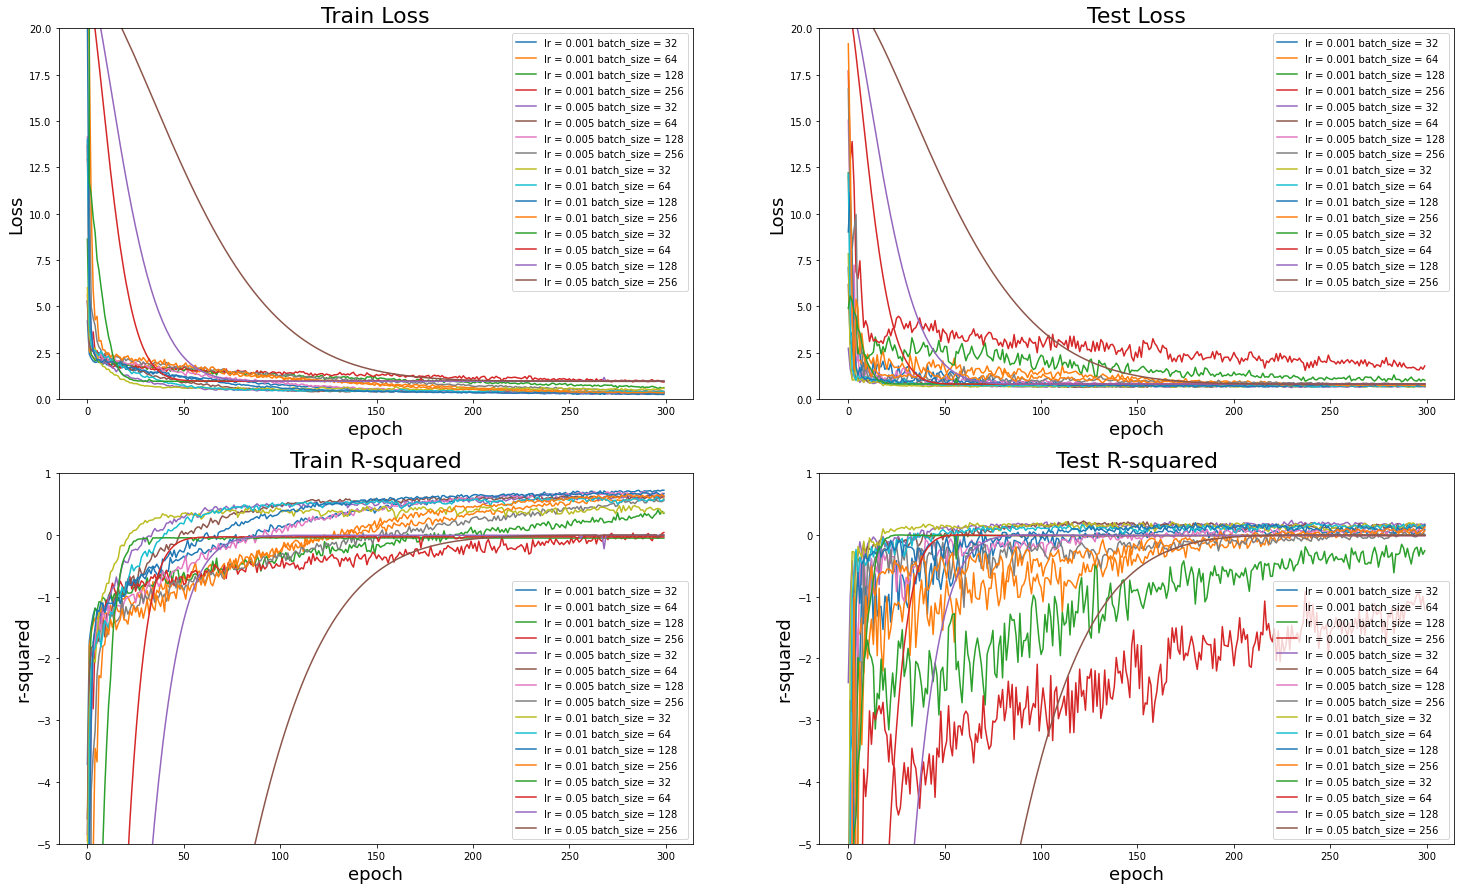

<Figure size 1800x1080 with 0 Axes>

In [17]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 20])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 20])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-5,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-5,1])

plt.show()

In [18]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.7240751281819754
0.5942173148025335
0.35092051244814354
0.03981638625874458
0.6177287511425167
0.6306869950753163
0.6708592830193234
0.558374096061549
0.3659751153017288
0.5772388320137994
0.6680824329558941
0.6296425959024432
-0.0511218329356074
-0.031247372873589353
-0.005371064670130576
-0.0006409469118911826
___________________

0.0876782353547294
0.06498798560554686
-0.2558924388888273
-1.2109963672248303
0.17600326590934023
0.1598669115699891
0.11340741111430686
0.010998371639702187
0.1418252568770657
0.15585291137055834
0.15430094263804384
0.1279850924287711
-0.007133245520700493
-0.010047854319398253
-0.009185318892941385
-0.006228549631510205
___________________

0.2491281108978467
0.3731580123305321
0.6113736152648925
0.9162180662155152
0.3391497142803975
0.34244819208979604
0.3114180088043213
0.4204683780670166
0.573111354540556
0.3912402592599392
0.31373928785324096
0.3529466032981873
0.9608060885698367
0.9601353347301483
0.9561533391475677
0.954697334766388
_____________

### 2 best models

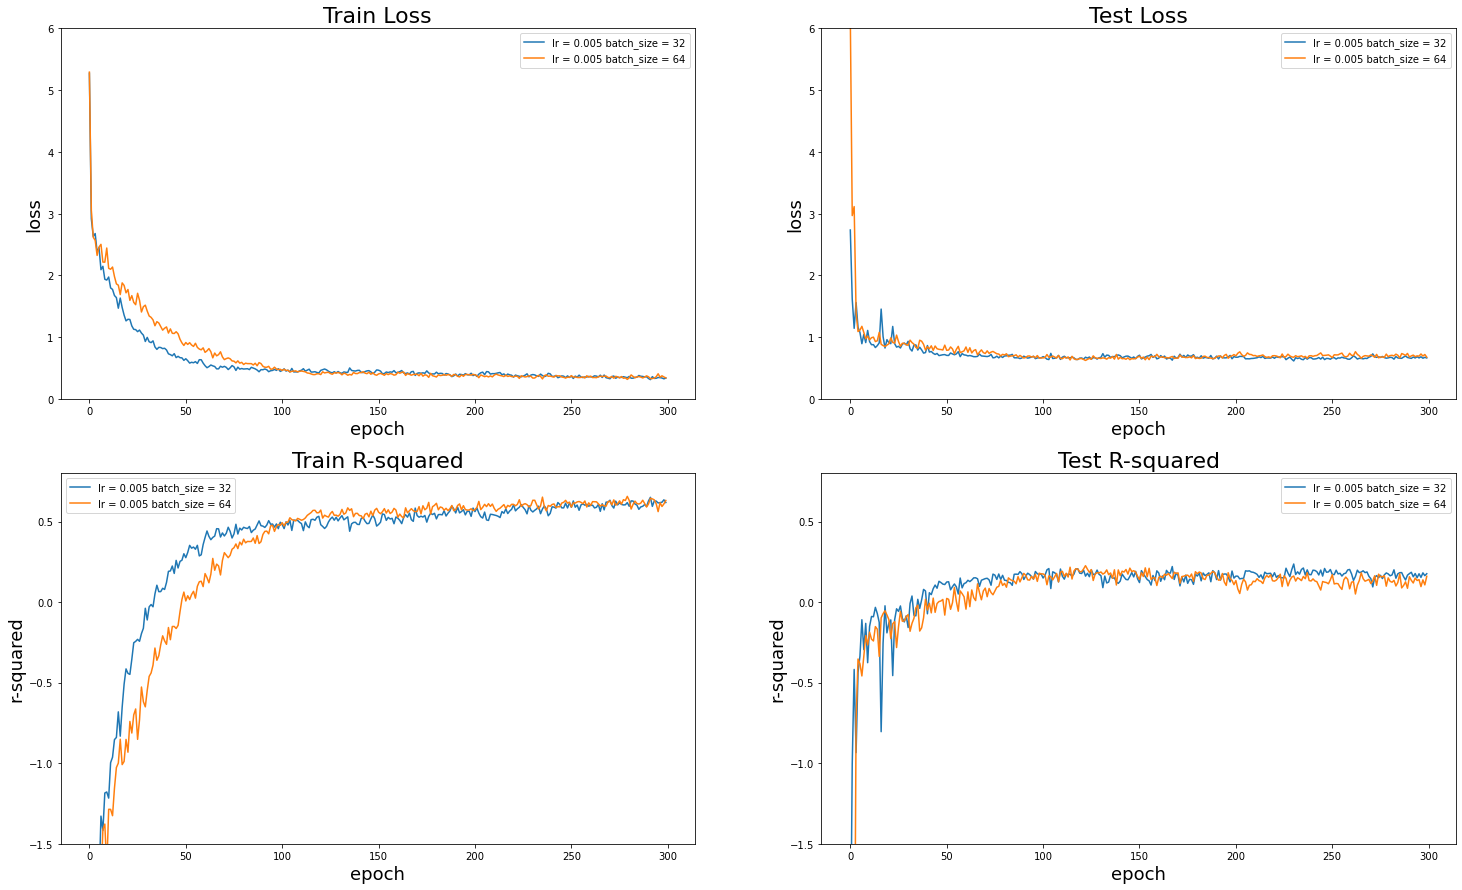

<Figure size 432x288 with 0 Axes>

In [22]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[4],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[5],label="lr = 0.005 batch_size = 64")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 6])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[4],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[5],label="lr = 0.005 batch_size = 64")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 6])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[4],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[5],label="lr = 0.005 batch_size = 64")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,0.8])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[4],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[5],label="lr = 0.005 batch_size = 64")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,0.8])
plt.show()

## 4.2. Training

In [25]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=353, shuffle=False)

In [26]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/solubility_pubchem_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 7.366661227267722, Accuracy: -6.931621849384574
Test Avg. loss: 5.5483174324035645, Accuracy: -5.061043622373108
################## EPOCH 2 ##################
Train Avg. loss: 2.80795637420986, Accuracy: -2.1189955585223506
Test Avg. loss: 4.568936347961426, Accuracy: -3.991156398944555
################## EPOCH 3 ##################
Train Avg. loss: 2.420021486023198, Accuracy: -1.701304475252656
Test Avg. loss: 1.5170810222625732, Accuracy: -0.6572761168735626
################## EPOCH 4 ##################
Train Avg. loss: 2.322935840357905, Accuracy: -1.5423153251824977
Test Avg. loss: 1.018247127532959, Accuracy: -0.11234439187308065
################## EPOCH 5 ##################
Train Avg. loss: 2.583568785501563, Accuracy: -1.8468954350303277
Test Avg. loss: 1.3271712064743042, Accuracy: -0.44981663688007
################## EPOCH 6 ##################
Train Avg. loss: 2.3934362919434258, Accuracy: -1.6348848542467722
Test 

Train Avg. loss: 1.1916076851927715, Accuracy: -0.2861137398363925
Test Avg. loss: 0.8135744333267212, Accuracy: 0.11124236741742244
################## EPOCH 49 ##################
Train Avg. loss: 1.097065030556658, Accuracy: -0.21192208986409308
Test Avg. loss: 0.8706263899803162, Accuracy: 0.04891806365954954
################## EPOCH 50 ##################
Train Avg. loss: 1.0450787881146306, Accuracy: -0.1343660601162927
Test Avg. loss: 0.8024593591690063, Accuracy: 0.12338453929491444
################## EPOCH 51 ##################
Train Avg. loss: 1.1132553893586863, Accuracy: -0.22355020269480527
Test Avg. loss: 0.8476758003234863, Accuracy: 0.07398968077349566
################## EPOCH 52 ##################
Train Avg. loss: 0.9191521820814713, Accuracy: -0.014488789046187826
Test Avg. loss: 0.8207282423973083, Accuracy: 0.10342736283896525
################## EPOCH 53 ##################
Train Avg. loss: 1.0465317290762197, Accuracy: -0.12212367548697899
Test Avg. loss: 0.87495976686

Train Avg. loss: 0.5941079634687175, Accuracy: 0.3436740411756747
Test Avg. loss: 0.7714219689369202, Accuracy: 0.1572901071090521
################## EPOCH 95 ##################
Train Avg. loss: 0.5772237071524495, Accuracy: 0.362451484382552
Test Avg. loss: 0.7336518168449402, Accuracy: 0.1985506162700531
################## EPOCH 96 ##################
Train Avg. loss: 0.5310358612433724, Accuracy: 0.4103039490522121
Test Avg. loss: 0.7867798805236816, Accuracy: 0.14051293281052624
################## EPOCH 97 ##################
Train Avg. loss: 0.5688392740228901, Accuracy: 0.37808762564547294
Test Avg. loss: 0.7019556164741516, Accuracy: 0.23317583143857312
################## EPOCH 98 ##################
Train Avg. loss: 0.5612052074916984, Accuracy: 0.3780231074153332
Test Avg. loss: 0.7314273118972778, Accuracy: 0.2009806332607188
################## EPOCH 99 ##################
Train Avg. loss: 0.5495641464772432, Accuracy: 0.39815156462693424
Test Avg. loss: 0.7361947298049927, Accur

Train Avg. loss: 0.4631887598813552, Accuracy: 0.4871727596034351
Test Avg. loss: 0.7501395344734192, Accuracy: 0.1805392144510639
################## EPOCH 142 ##################
Train Avg. loss: 0.46444971146790875, Accuracy: 0.4845170045362237
Test Avg. loss: 0.7674939036369324, Accuracy: 0.16158110544479687
################## EPOCH 143 ##################
Train Avg. loss: 0.449295198139937, Accuracy: 0.5029814723832912
Test Avg. loss: 0.7404108047485352, Accuracy: 0.19116703860093553
################## EPOCH 144 ##################
Train Avg. loss: 0.4589529474792273, Accuracy: 0.4927619792999508
Test Avg. loss: 0.6992940902709961, Accuracy: 0.2360833825213028
################## EPOCH 145 ##################
Train Avg. loss: 0.45858947803144867, Accuracy: 0.4924234759708992
Test Avg. loss: 0.7338262796401978, Accuracy: 0.1983600666369303
################## EPOCH 146 ##################
Train Avg. loss: 0.475538128744001, Accuracy: 0.4703191999354479
Test Avg. loss: 0.7299019694328308, A

Train Avg. loss: 0.4413096140260282, Accuracy: 0.5119827873952753
Test Avg. loss: 0.6918308138847351, Accuracy: 0.24423637918967034
################## EPOCH 188 ##################
Train Avg. loss: 0.4595965380253999, Accuracy: 0.4986568632296454
Test Avg. loss: 0.7452594041824341, Accuracy: 0.1858703700783655
################## EPOCH 189 ##################
Train Avg. loss: 0.4582177724527276, Accuracy: 0.49634088549030325
Test Avg. loss: 0.6869080066680908, Accuracy: 0.2496140582454882
################## EPOCH 190 ##################
Train Avg. loss: 0.4582893213500147, Accuracy: 0.49560376132908923
Test Avg. loss: 0.7420737147331238, Accuracy: 0.189350433634343
################## EPOCH 191 ##################
Train Avg. loss: 0.5935591096463411, Accuracy: 0.36548102122840537
Test Avg. loss: 0.6892617344856262, Accuracy: 0.24704287456017382
################## EPOCH 192 ##################
Train Avg. loss: 0.5351631278577058, Accuracy: 0.4171982073060549
Test Avg. loss: 0.6731612086296082,

Train Avg. loss: 0.39720585666920827, Accuracy: 0.5565974387749175
Test Avg. loss: 0.6873738765716553, Accuracy: 0.24910519540649734
################## EPOCH 234 ##################
Train Avg. loss: 0.4984749775865804, Accuracy: 0.4657291404575211
Test Avg. loss: 0.6586254239082336, Accuracy: 0.28051033570973005
################## EPOCH 235 ##################
Train Avg. loss: 0.4099253325358681, Accuracy: 0.5504029438456283
Test Avg. loss: 0.6533817052841187, Accuracy: 0.286238640591189
################## EPOCH 236 ##################
Train Avg. loss: 0.4854541874450186, Accuracy: 0.47656077487546195
Test Avg. loss: 0.7167348861694336, Accuracy: 0.21703092161219995
################## EPOCH 237 ##################
Train Avg. loss: 0.43415986325429834, Accuracy: 0.5211207298224984
Test Avg. loss: 0.7940716743469238, Accuracy: 0.1325472763164468
################## EPOCH 238 ##################
Train Avg. loss: 0.4744261140408723, Accuracy: 0.4750400528679697
Test Avg. loss: 0.7403635382652283

Train Avg. loss: 0.4708285331726074, Accuracy: 0.4813263291551133
Test Avg. loss: 0.7766253352165222, Accuracy: 0.15160580395171297
################## EPOCH 280 ##################
Train Avg. loss: 0.4216990393141042, Accuracy: 0.5327187183797863
Test Avg. loss: 0.7029175758361816, Accuracy: 0.2321250616450523
################## EPOCH 281 ##################
Train Avg. loss: 0.42377184914506, Accuracy: 0.5361984283067928
Test Avg. loss: 0.7495781183242798, Accuracy: 0.18115253057348468
################## EPOCH 282 ##################
Train Avg. loss: 0.4281371728233669, Accuracy: 0.5295769148972707
Test Avg. loss: 0.7271209955215454, Accuracy: 0.20568493242797503
################## EPOCH 283 ##################
Train Avg. loss: 0.41039758127020753, Accuracy: 0.5434442692704952
Test Avg. loss: 0.671271800994873, Accuracy: 0.2666952776439222
################## EPOCH 284 ##################
Train Avg. loss: 0.46203452607859735, Accuracy: 0.495892550259004
Test Avg. loss: 0.6880152225494385, Ac

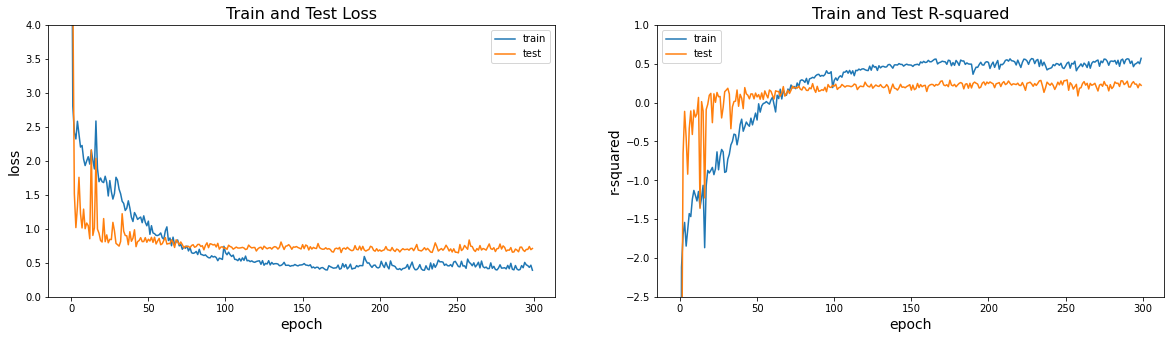

<Figure size 1440x360 with 0 Axes>

In [29]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,4])
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.set_ylim([-2.5,1])
ax2.legend()
plt.show()

In [30]:
model = FCNN()
model.load_state_dict(torch.load('../../models/solubility_pubchem_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.6470382
MSE: 0.6466519
RMSE: 0.8041467
R2 Square 0.29359031778478084 

